# Semester 4 Coding Portfolio Part 5: Regularization for Trees

This notebook covers the following topics:
 - Decision Trees: CART
 - Pruning Decision Trees
 - Resampling: Undersampling, Oversampling and SMOTENC
 - Random Forest & XGBoost
 - Ensemble Modeling: Bagging, Stacking and Voting

This notebook is expected to take around 20 hours to complete:
 - 4 hours for the formative part
 - 6 hours of self-study on the topics covered by this notebook
 - 10 hours for the summative part of this notebook

Like all notebooks in this portfolio, it is split into two sections:
 - Formative 
 - Summative

<b>Formative section</b><br>
Simply complete the given functions! You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

<b>Summative section</b><br>
In this section, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [129]:
# TODO: Please enter your student number here
STUDENT_NUMBER = 14806762

# Formative Section
Please do not add additional cells to this section, and do not delete given code. Simply fill out the code or answer questions in the given cells.

### Part 0: Load data
This notebook is divided into two parts. In the first half, a decision tree is applied to Heart Disease UCI dataset and the decision tree is regularized by different pruning methods. A plot of Model performance will be utilized to examine overfitting and underfitting.

In the second half, crucial resampling methods and ensemble methods are introduced. Another dataset, UCI Adult dataset, will be utilized.

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from scipy.stats import beta, norm, bernoulli

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from decimal import Decimal
from collections import Counter

In [131]:
# Implement a function to plot the confusion matrix.
# The model should contain a prediction function called predict().
# The function is only implemented to be a convenient plotting method,
# it is not suitable for general use.
# This is only for binary classification
def print_plot_confusion_matrix(modelname,X_test,y_test):
    # Making predictions
    predictions = modelname.predict(X_test)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute confusion_matrix
    labels_confu = np.unique(np.concatenate((y_test, predictions)))
    cm = confusion_matrix(y_test, predictions, labels=labels_confu)

    # Print FNR and FPR
    TN, FP, FN, TP = cm.ravel()
    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)
    print("False Negative Rate (FNR):", FNR, "&& False Positive Rate (FPR):", FPR)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_confu)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for model {modelname.__class__.__name__}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return FNR, FPR

## **1.** Decision Trees: CART

In this section, you will use the CART algorithm in sklearn package to build and interpret a decision tree classifier. Apply this classifier to a real-world dataset, compute confusion matrix, and then intepret the plotted decision tree structure.

The Heart Disease UCI dataset is a well-known dataset from the UCI Machine Learning Repository. It contains data used to predict the presence of heart disease in patients.

If you want to know the features, here is some information on the variables in this dataset:
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type:
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved   
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy        
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
    - Value 0: < 50% diameter narrowing, which is no disease.
    - Value more than 0: > 50% diameter narrowing (in any major vessel), which indicates disease.
   
The dependent variable is the last one which indicates the presence or absence of the disease.

Load the "Heart Disease UCI" dataset & remove missing values. We don't focus on pre-processing this time.

In [132]:
# import data & add column names
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]
df = pd.read_csv('sem4_portfolio_5_data_processed.cleveland.data', names=column_names, header=None)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [133]:
# drop missing values
df.replace('?', np.nan, inplace=True)  # missing entries are marked with '?'
df.dropna(inplace=True)

In [134]:
# Split the DataFrame into features and target
X = df.drop('num', axis=1)  # Drop the target
y = df['num']  # Target column

# Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print([type(X_train.iloc[0,i]) for i in range(len(X_train.columns))])

[<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'str'>, <class 'str'>]


Now we will apply a CART model.

Note: We always need to check the data type beforehand. If we are using ID3, we need to discretize the continuous variables. While CART prefers continuous variables, it allows both categorical and numeric variables.

In [135]:
# TODO : Define a decision tree using sklearn and fit it.
#!# BEGIN SOLUTION
# Create a DecisionTreeClassifier object
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
cart_model.fit(X_train, y_train)

#!# END SOLUTION

DecisionTreeClassifier(random_state=42)

Now let's make some predictions on the test set to see the result:

Accuracy: 0.4833


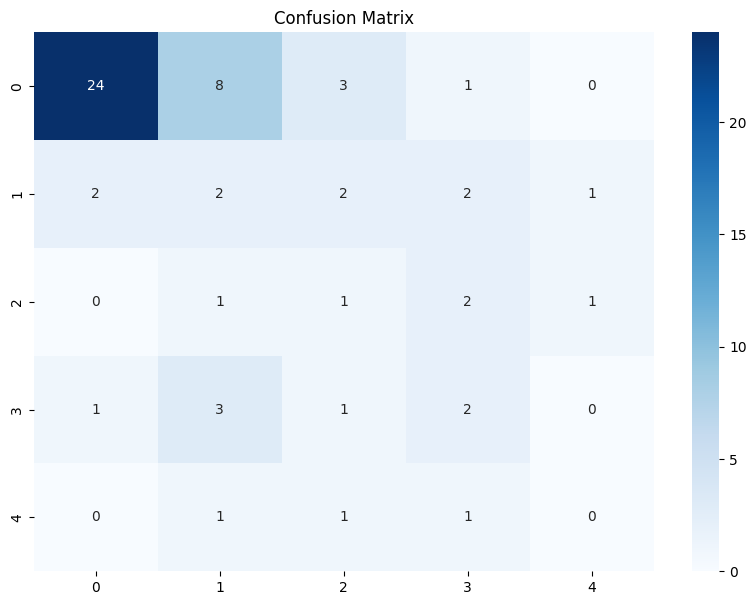

In [136]:
# Making predictions
predictions = cart_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.show()

Finally, we visualize the decision tree:

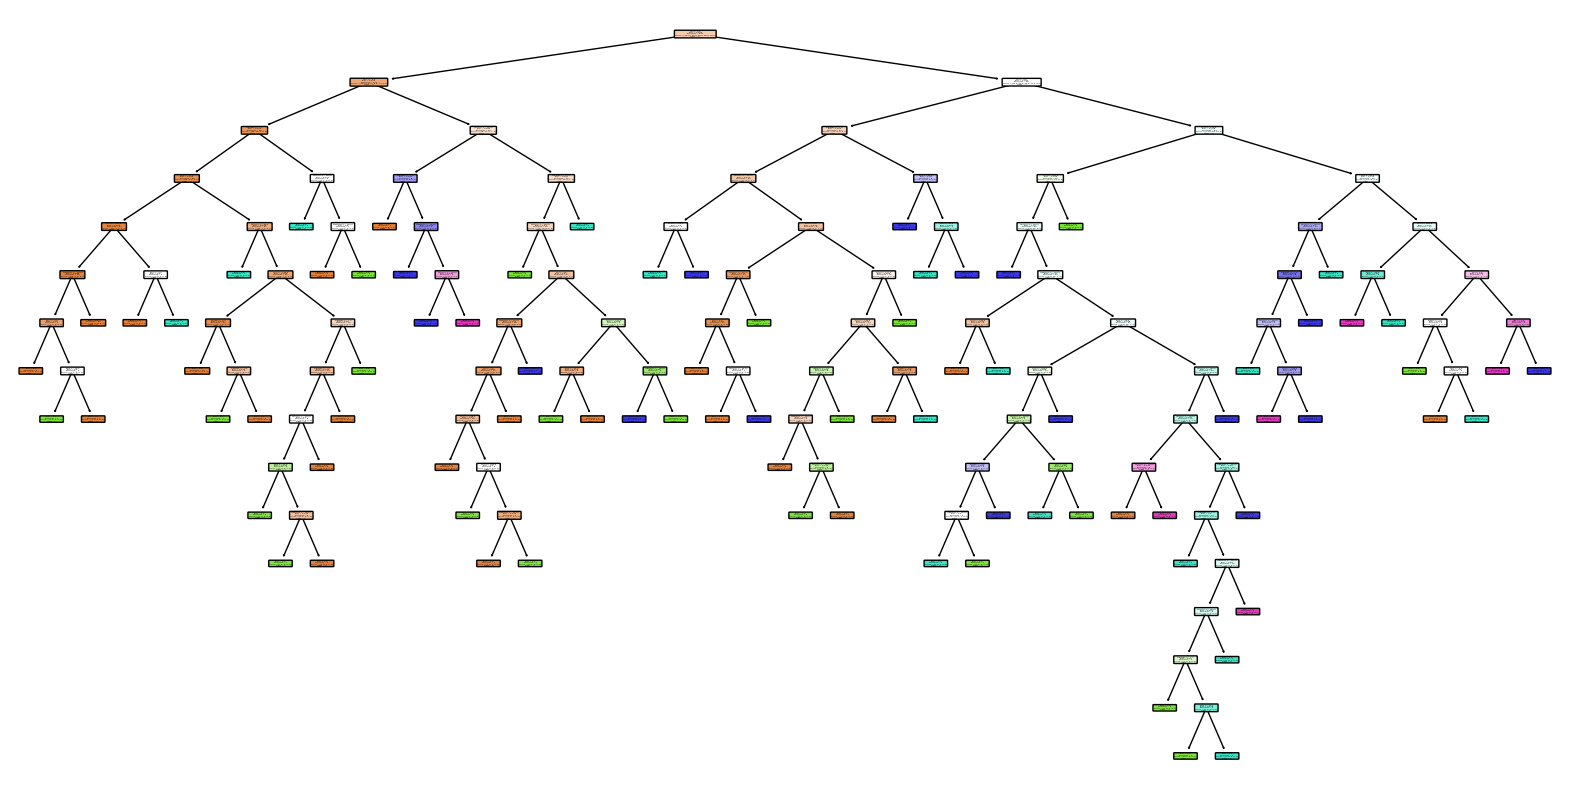

In [137]:
plt.figure(figsize=(20,10))
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          class_names=['0', '1', '2', '3', '4'],  # Update class names as appropriate
          feature_names=list(X_train.columns))       # Ensure X_train.columns is accessible
plt.show()

According to the confusion matrix, our model is highly biased. Our prediction is mainly focusing on the class "0". In fact, all values other than 0 are indicative of having disease, and based on this information, we can turn problem into a binary classification. We map the values and do the decision tree again.

Note: there are other solutions. For simplicity, we use the binary classification here.

In [138]:
# TODO : Map value 0 to string "no disease", values 1-5 to string "disease", store the result in df['bin_class']
#!# BEGIN SOLUTION
num_replacements = {0: 'no disease', 
                    1: 'disease',
                    2: 'disease',
                    3: 'disease',
                    4: 'disease',
                    5: 'disease'}
df['bin_class'] = df['num'].replace(num_replacements)

#!# END SOLUTION

# Split the DataFrame into features and target
X = df.drop(['num','bin_class'], axis=1)  # Drop the target
y = df['bin_class']  # Target column

# Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print([type(X_train.iloc[0,i]) for i in range(len(X_train.columns))])

[<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>, <class 'str'>, <class 'str'>]


In [139]:
# TODO : Define a decision tree using sklearn and fit it. The same as the one above.
#!# BEGIN SOLUTION
# Create a DecisionTreeClassifier object
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
cart_model.fit(X_train, y_train)

#!# END SOLUTION

DecisionTreeClassifier(random_state=42)

Accuracy: 0.7833


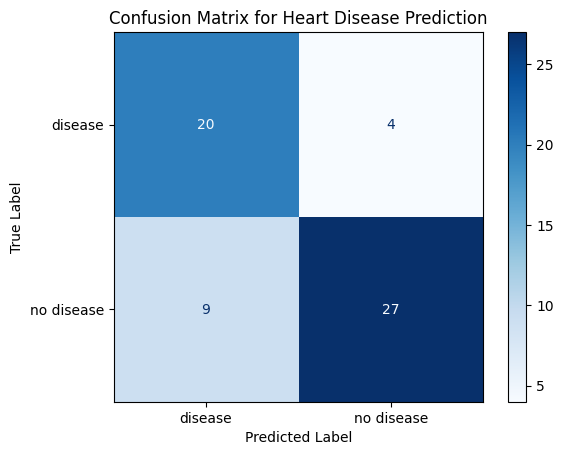

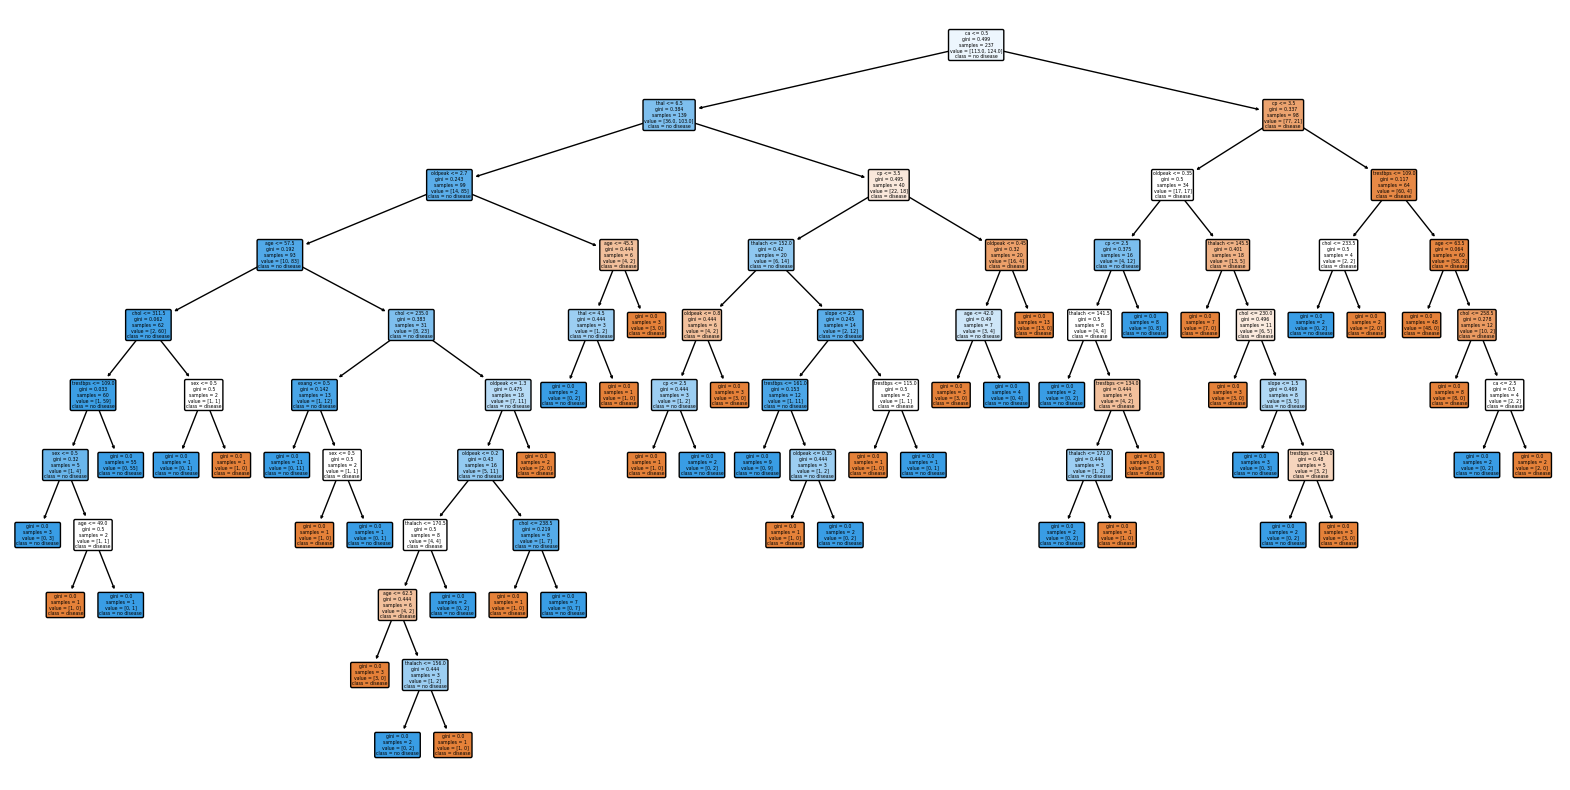

In [140]:
def predict_plot_metric_and_tree(modelname,X_test,y_test):
    # Making predictions
    predictions = modelname.predict(X_test)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Compute confusion matrix
    labels_confu = np.unique(np.concatenate((y_test, predictions)))
    cm = confusion_matrix(y_test, predictions, labels=labels_confu)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_confu)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Heart Disease Prediction')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Plot the tree
    plt.figure(figsize=(20,10))
    plot_tree(modelname, 
              filled=True, 
              rounded=True, 
              class_names=list(map(str, modelname.classes_)),  # Update class names as appropriate
              feature_names=list(X_test.columns))       # Ensure X_test.columns is accessible
    plt.show()

# Apply the function
predict_plot_metric_and_tree(cart_model,X_test,y_test)

## **2.** Pruning Decision Trees

Pruning is a technique for modifying models to achieve regularization. We will introduce three pruning methods. They can all be implemented simply by changing the function arguments.

Accuracy: 0.7667


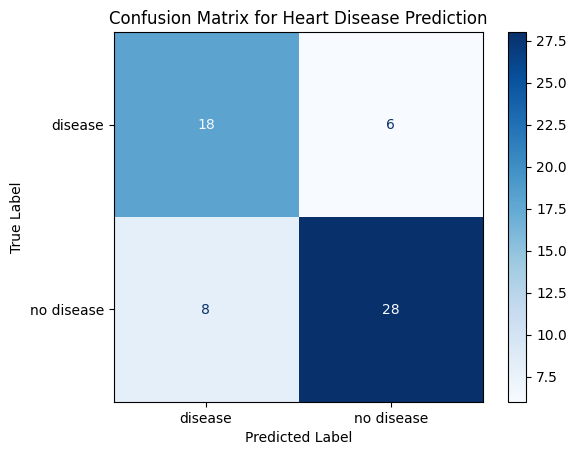

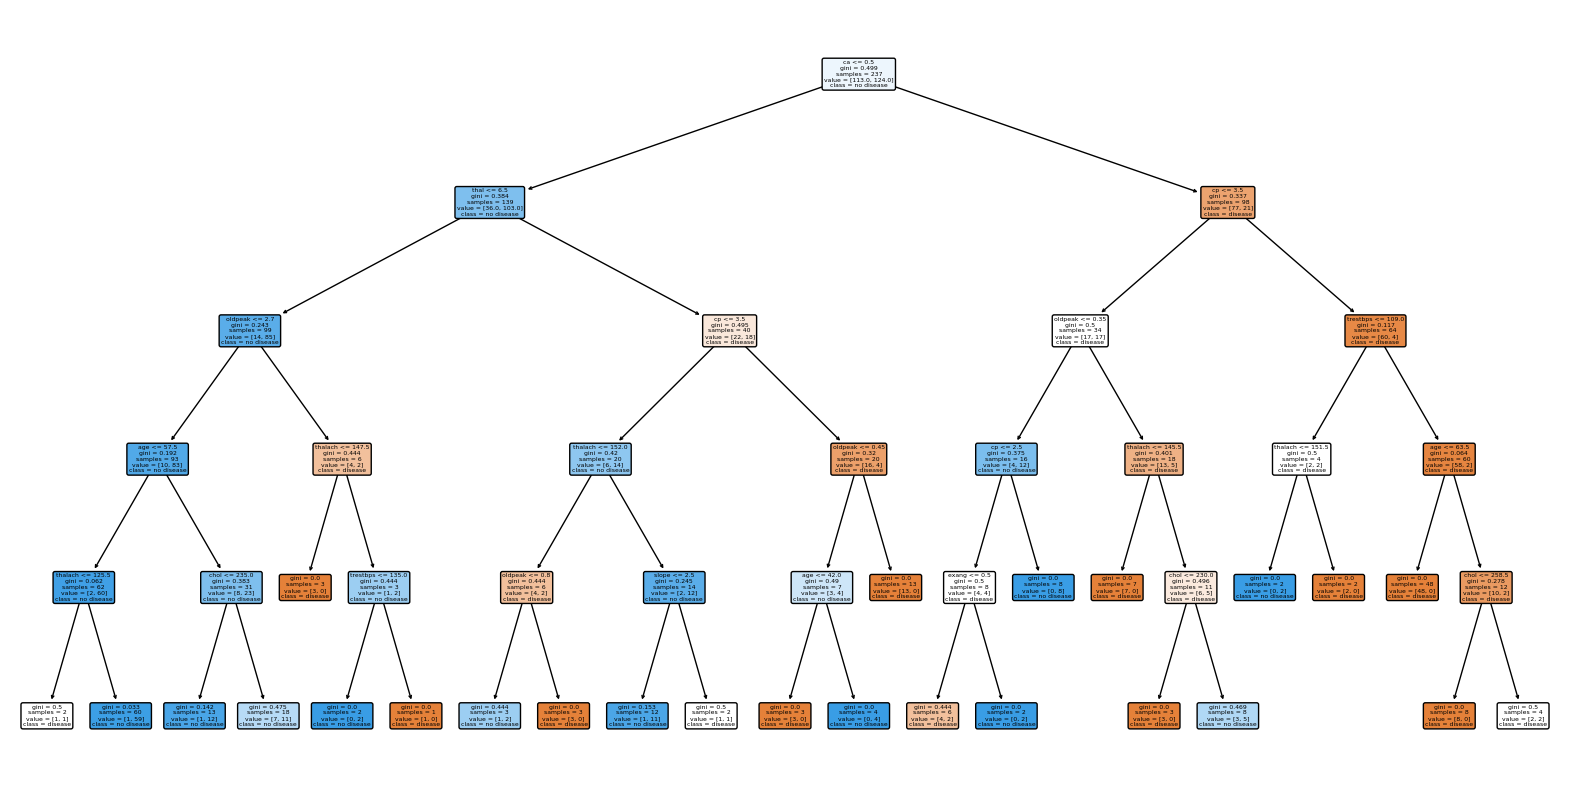

In [141]:
# Method 1: Limiting the maximum depth of the tree

# TODO : Use the parameter max_depth to do the pruning.
#!# BEGIN SOLUTION
max_depth_model = DecisionTreeClassifier(max_depth=5)
#!# END SOLUTION
max_depth_model.fit(X_train, y_train)
predict_plot_metric_and_tree(max_depth_model,X_test,y_test)

Accuracy: 0.7667


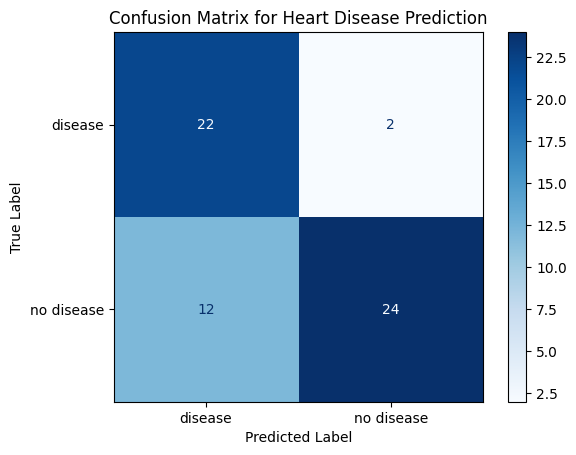

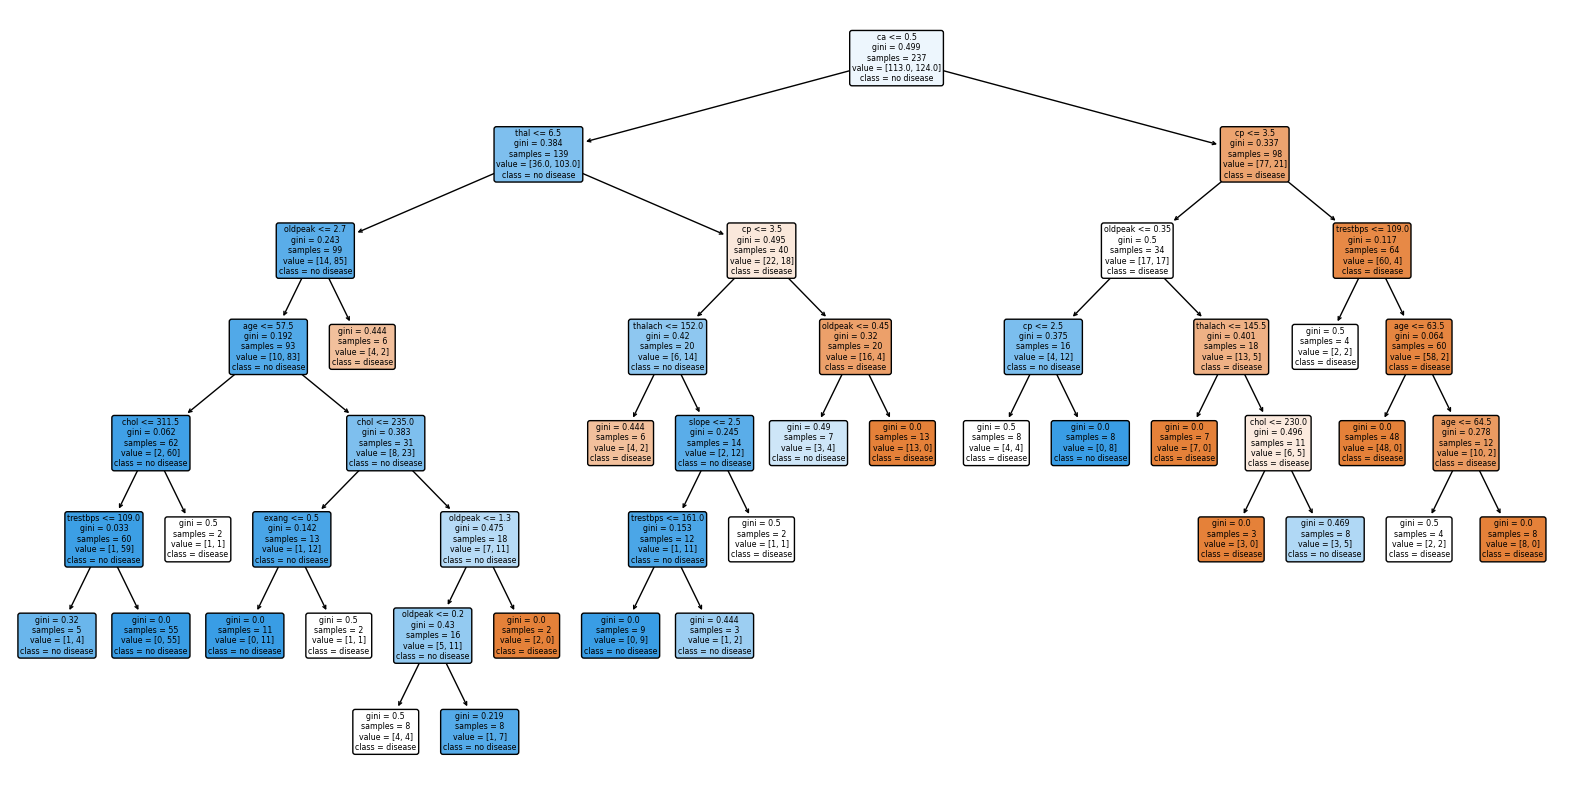

In [142]:
# Method 2: Setting the minimum number of samples required to split an internal node

# TODO : Use the parameter min_samples_split to do the pruning.
#!# BEGIN SOLUTION
min_samples_split_model = DecisionTreeClassifier(min_samples_split=10)
#!# END SOLUTION
min_samples_split_model.fit(X_train, y_train)
predict_plot_metric_and_tree(min_samples_split_model,X_test,y_test)

Method 3 is cost-complexity pruning. This method gives us a easy way to contral the model complexity to become the one we want. In some cases, we may need to try several times to find the best value for CCP-Alpha. Here we use the value of index 6 (Index 6: ccp_alpha = 0.005625879043600562), it is a result from the later part.

Index 0: ccp_alpha = 0.0
Index 1: ccp_alpha = 0.002766057196436945
Index 2: ccp_alpha = 0.003616636528028934
Index 3: ccp_alpha = 0.003894839337877311
Index 4: ccp_alpha = 0.004017512817022814
Index 5: ccp_alpha = 0.005438349742147208
Index 6: ccp_alpha = 0.005625879043600562
Index 7: ccp_alpha = 0.005625879043600562
Index 8: ccp_alpha = 0.005625879043600563
Index 9: ccp_alpha = 0.005625879043600563
Index 10: ccp_alpha = 0.006065400843881857
Index 11: ccp_alpha = 0.0066451769953199125
Index 12: ccp_alpha = 0.0076183778715424285
Index 13: ccp_alpha = 0.007665260196905771
Index 14: ccp_alpha = 0.008438818565400845
Index 15: ccp_alpha = 0.008892518488271856
Index 16: ccp_alpha = 0.009724733775366687
Index 17: ccp_alpha = 0.013502109704641347
Index 18: ccp_alpha = 0.014870358684160256
Index 19: ccp_alpha = 0.015939990623534926
Index 20: ccp_alpha = 0.021097046413502116
Index 21: ccp_alpha = 0.03586497890295359
Index 22: ccp_alpha = 0.0401355018785125
Index 23: ccp_alpha = 0.134566277437911

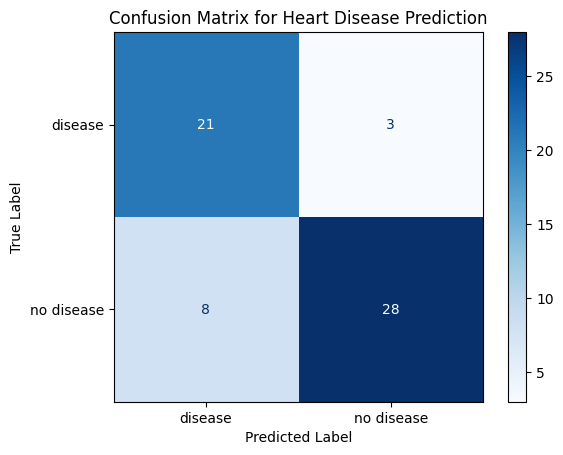

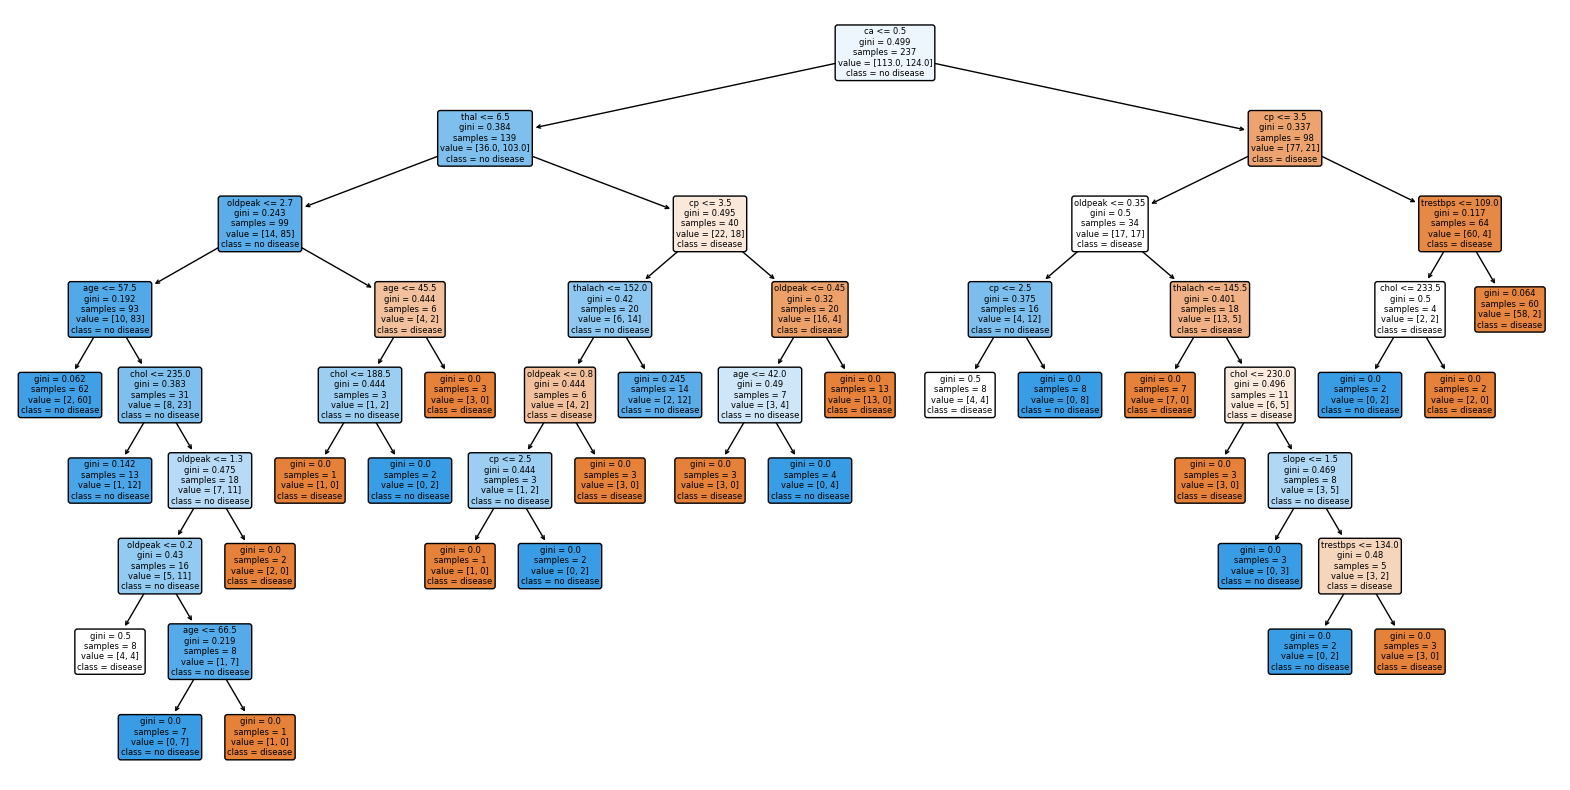

In [143]:
# Method 3: Using cost complexity pruning
# You need to have an initial tree to do so. Run the initial tree in part 1 to get cart_model.

# TODO : Use the function cart_model.cost_complexity_pruning_path to get the ccp_alphas. 
# TODO : And put ccp_alphas[X] or ccp_alphas[6] into the tree parameter. 
#!# BEGIN SOLUTION
path = cart_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alpha_model = DecisionTreeClassifier(ccp_alpha=ccp_alphas[6])
#!# END SOLUTION

ccp_alpha_model.fit(X_train, y_train)
print("\n".join([f"Index {index}: ccp_alpha = {ccp_alpha}" for index, ccp_alpha in enumerate(ccp_alphas)]))
predict_plot_metric_and_tree(ccp_alpha_model,X_test,y_test)

In this part, we will plot the model performance to check if overfitting or underfitting has occurred. This also helps us to choose the value for CCP-Alpha.

You can check them using other methods. In the part of regularization, our goal is to find a suitable complexity at which the model is neither overfitted nor underfitted.

Based on the learning curve we have learned last semester, we can use training accuracy and validation accuracy to represent model performance. Now let's compute them as the y-axis and effective alpha as the x-axis.

In [144]:
# Check if ccp_alphas is well defined
assert np.array_equal(ccp_alphas, path.ccp_alphas)

# Exclude the maximum value which would prune the entire tree
ccp_alphas = ccp_alphas[:-1]

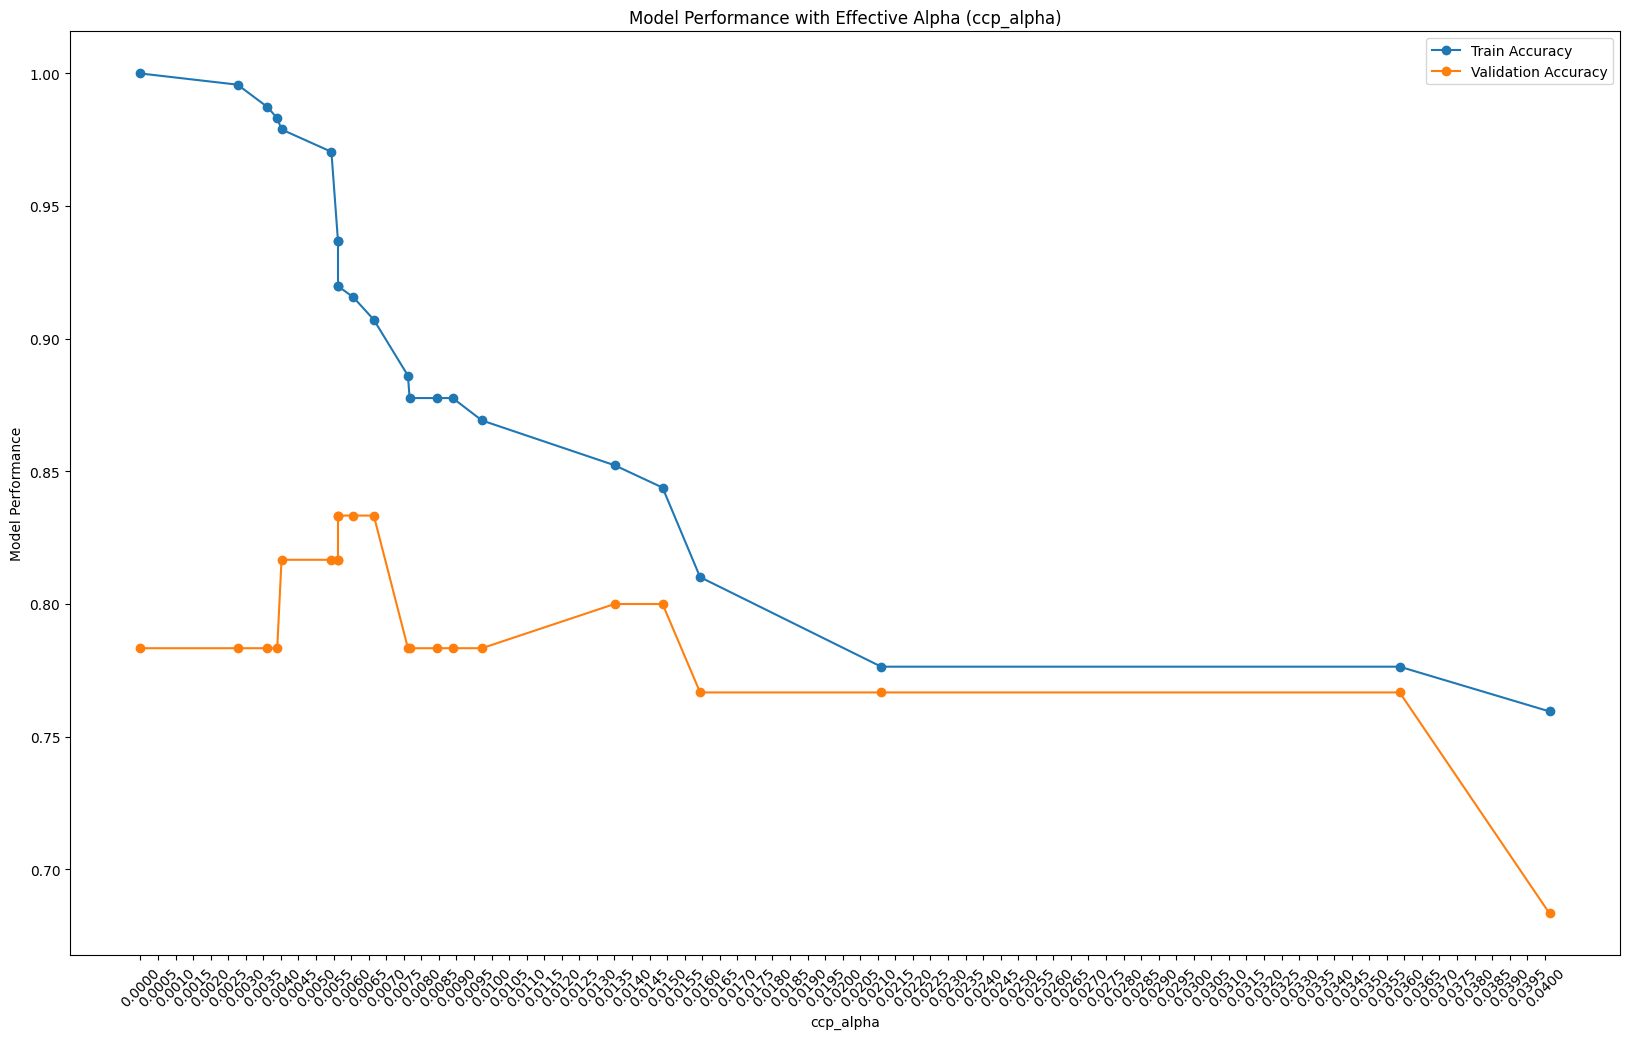

In [145]:
# Train trees using different ccp_alpha values and store their performance
train_scores = []
val_scores = []

# TODO : For each ccp_alpha value, compute the accuracy for training set and accuracy for validation set.
# TODO : Record the results in train_scores and val_scores.
#!# BEGIN SOLUTION
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, tree.predict(X_train)))
    val_scores.append(accuracy_score(y_test, tree.predict(X_test)))
#!# END SOLUTION

# Plot the results
plt.figure(figsize=(20, 12))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train Accuracy')
plt.plot(ccp_alphas, val_scores, marker='o', label='Validation Accuracy')
plt.xticks(np.arange(ccp_alphas[0], ccp_alphas[-1], step=0.0005),rotation=45)
#plt.xlim(0.005,0.007)
plt.xlabel('ccp_alpha')
plt.ylabel('Model Performance')
plt.title('Model Performance with Effective Alpha (ccp_alpha)')
plt.legend()
plt.show()

In [146]:
# Evaluate and compare the models
print("Original CART Model Accuracy: ", cart_model.score(X_test, y_test))
print("Max Depth Model Accuracy: ", max_depth_model.score(X_test, y_test))
print("Min Samples Split Model Accuracy: ", min_samples_split_model.score(X_test, y_test))
print("CCP Alpha Model Accuracy: ", ccp_alpha_model.score(X_test, y_test))

Original CART Model Accuracy:  0.7833333333333333
Max Depth Model Accuracy:  0.7666666666666667
Min Samples Split Model Accuracy:  0.7666666666666667
CCP Alpha Model Accuracy:  0.8166666666666667


Due to limited space, no other decision trees will be shown here. Decision tree is a simple, flexible and potential-rich approach. It can obviously be used not only for binary classification, but also for multi-class classification and for regression tasks (see DecisionTreeRegressor for more information).

## **3.** Resampling: Undersampling, Oversampling and SMOTENC

In this part, we'll explore several resampling methods to modify the sample distribution.

The task at hand will be predicting the sex of entries in UCI Adult dataset based on the independent variables. We will find that there is a class imbalance between both sexes and we will use resampling to solve this issue. In this notebook, we will explore three methods to handle this.

### Overview of the UCI Adult Dataset

The UCI Adult dataset, also known as the "Census Income" dataset, is a widely used dataset for machine learning tasks, particularly for classification problems. The dataset was extracted from the 1994 U.S. Census Bureau database and consists of approximately 48,842 instances. The primary goal is to predict whether an individual earns more than $50,000 per year based on various demographic attributes.

### Main Features

The dataset includes the following features:

1. **Age**: The age of the individual.
2. **Workclass**: The working class of the individual, such as Private, Self-emp-not-inc, Local-gov, etc.
3. **Fnlwgt**: Final weight, representing the number of people the census believes the entry represents.
4. **Education**: The highest level of education attained by the individual.
5. **Education-Num**: Numerical representation of education level.
6. **Marital-Status**: The marital status of the individual, such as Married-civ-spouse, Divorced, Never-married, etc.
7. **Occupation**: The occupation of the individual.
8. **Relationship**: The relationship of the individual to their household.
9. **Race**: The race of the individual.
10. **Sex**: The gender of the individual.
11. **Capital-Gain**: Capital gains income.
12. **Capital-Loss**: Capital loss.
13. **Hours-Per-Week**: The number of hours the individual works per week.
14. **Native-Country**: The native country of the individual.
15. **Income**: The variable indicating whether the individual earns more than $50,000 per year.

Typically, the feature “income” would be used as the dependent variable, but today, for demonstration purposes, we will use the feature “sex” as the dependent variable.

In the UCI Adult dataset, the "Sex" feature is encoded as follows:
- **0**: Female
- **1**: Male

This feature is crucial for understanding gender-related differences in income, work hours, and other socio-economic factors. In many analyses, researchers may explore whether gender has a significant impact on the likelihood of earning more than $50,000 per year and how it interacts with other features like education, occupation, and work hours.

Now let's start by importing the data.

You can use the following code to import the data.

You can also download the dataset by yourself. I can be done by using package aif360 and the function aif360.datasets.AdultDataset.

Note:

If you have compatibility problem between sklearn and imbalanced-learn. You can try the upgrade or downgrade them:

!pip install --upgrade scikit-learn imbalanced-learn

!pip install scikit-learn==1.5.3 imbalanced-learn==0.13.0

And restart the notebook.

In [147]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN

In [148]:
# Define the file paths
desktop_path = os.path.expanduser("./")
data_file = os.path.join(desktop_path, "/Users/yuchia/Desktop/sm4_portfolio/regularization_for_trees/sem4_portfolio_5_data_adult.data")
test_file = os.path.join(desktop_path, "/Users/yuchia/Desktop/sm4_portfolio/regularization_for_trees/sem4_portfolio_5_data_adult.test")

# Define column names based on adult dataset documentation
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Load the dataset
# Note: Skip initial spaces in the columns and handle missing values ("?")
train_df = pd.read_csv(data_file, header=None, names=column_names, skipinitialspace=True, na_values="?")
test_df = pd.read_csv(test_file, header=0, names=column_names, skipinitialspace=True, na_values="?")

# Replace any instances of "unknown" with a missing value indicator (NaN)
train_df.replace("unknown", pd.NA, inplace=True)
test_df.replace("unknown", pd.NA, inplace=True)

# Drop any rows that contain missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Mapping the 'sex' column: convert Female->0 and Male->1. 
# The conversion strips any extra spaces, converts to lowercase, and then maps.
mapping = {'female': 0, 'male': 1}

# Create y_train and y_test by using the "sex" column
y_train = train_df['sex'].str.strip().str.lower().map(mapping)
y_test  = test_df['sex'].str.strip().str.lower().map(mapping)

# Create X_train and X_test by dropping the "sex" column from the data
X_train = train_df.drop(columns=["sex"])
X_test  = test_df.drop(columns=["sex"])

# Optionally, display some results to verify
print(X_train.head())
print(y_train.unique())
print(train_df.shape)
print(test_df.shape)

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race  capital-gain  \
0       Never-married       Adm-clerical  Not-in-family  White          2174   
1  Married-civ-spouse    Exec-managerial        Husband  White             0   
2            Divorced  Handlers-cleaners  Not-in-family  White             0   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black             0   
4  Married-civ-spouse     Prof-specialty           Wife  Black             0   

   capital-loss  hours-per-week native-country income  
0             0              40  United-States  <=50K  
1             0              13  U

In [149]:
# Check data types, should have clear distinction between categorical and numerical
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

Let's train a model without resampling for later comparison.

Accuracy: 0.8106
False Negative Rate (FNR): 0.14171676357544102 && False Positive Rate (FPR): 0.2880113983309587


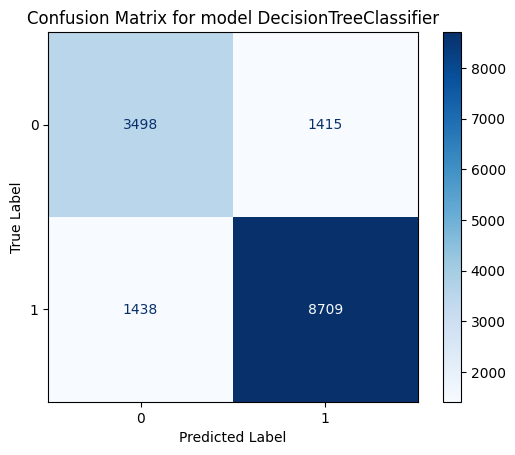

DecisionTreeClassifier(random_state=42)

In [150]:
def train_plain_CART_print_plot(X_train, X_test, y_train, y_test):
    # Train a simple CART and use the function print_plot_confusion_matrix
    cart_model = DecisionTreeClassifier(random_state=42)
    cart_model.fit(X_train, y_train)
    print_plot_confusion_matrix(cart_model, X_test, y_test)
    return cart_model

def train_CART_onehot_print_plot(X_train, X_test, y_train, y_test):
    """
    This function applies one hot encoding to the training and test features,
    then calls the train_plain_CART_print_plot function to train and evaluate a CART model.
    """
    # Identify categorical columns (assuming they are of type 'object')
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    # Apply one-hot encoding using pandas get_dummies; drop_first to avoid dummy variable trap.
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_encoded  = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

    # Align the dataframes so they have the same columns; fill missing dummy columns with 0.
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

    # Train CART using the encoded features.
    return train_plain_CART_print_plot(X_train_encoded, X_test_encoded, y_train, y_test)

train_CART_onehot_print_plot(X_train, X_test, y_train, y_test)

Let's start oversampling and undersampling.

Accuracy: 0.8129
False Negative Rate (FNR): 0.18892283433527152 && False Positive Rate (FPR): 0.18339100346020762


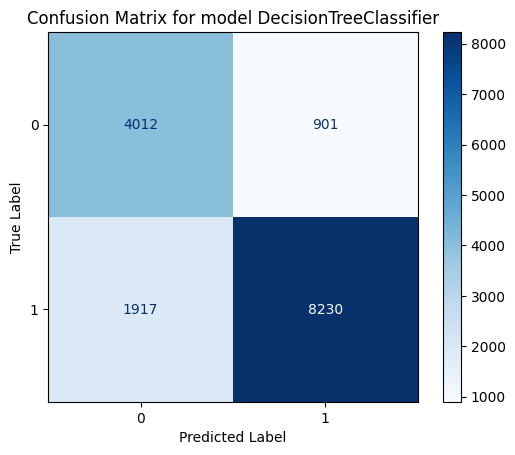

DecisionTreeClassifier(random_state=42)

In [151]:
# Method 1: Undersampling using RandomUnderSampler

# TODO : Apply RandomUnderSampler() to implement under-sampling 
#!# BEGIN SOLUTION
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
#!# END SOLUTION

train_CART_onehot_print_plot(X_train_rus, X_test, y_train_rus, y_test)

Accuracy: 0.8062
False Negative Rate (FNR): 0.14368778949443184 && False Positive Rate (FPR): 0.29717077142275594


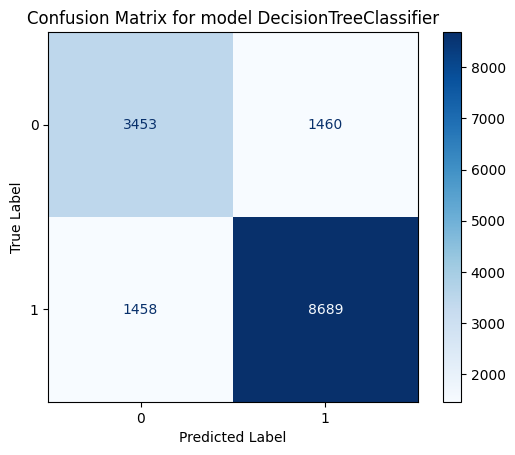

DecisionTreeClassifier(random_state=42)

In [152]:
# Method 2: Oversampling using RandomOverSampler

# TODO : Apply RandomOverSampler() to implement over-sampling 
#!# BEGIN SOLUTION
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
#!# END SOLUTION

train_CART_onehot_print_plot(X_train_ros, X_test, y_train_ros, y_test)

In this part, we use SMOTENC to carry out the oversampling. SMOTENC is relatively slow because it has to work with numeric and categorical data at the same time. If all your data is numeric or categorical, you should use SMOTE or SMOTEN, respectively.

Accuracy: 0.8076
False Negative Rate (FNR): 0.1605400611018035 && False Positive Rate (FPR): 0.25809077956442095


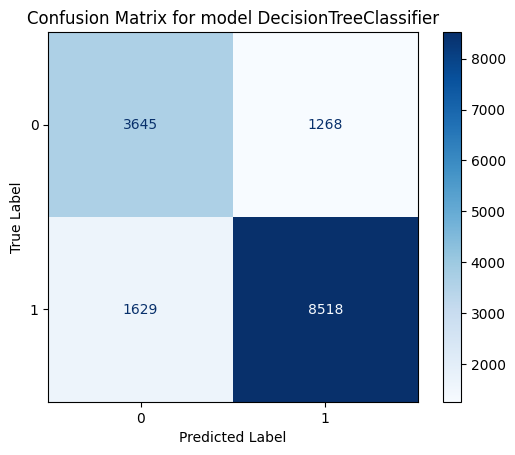

DecisionTreeClassifier(random_state=42)

In [153]:
# Method 3: Oversampling using SMOTENC

# Identify categorical columns by checking for the 'object' dtype.
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

# TODO : Apply SMOTENC() to implement an over-sampling with SMOTENC
#!# BEGIN SOLUTION
smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)
#!# END SOLUTION

train_CART_onehot_print_plot(X_train_smotenc, X_test, y_train_smotenc, y_test)

Now, we want to control for the sample size of the minority group. We want it to be 75% of the majority. We can do this by changing the “Sampling Strategy” argument.

Accuracy: 0.8093
False Negative Rate (FNR): 0.1532472652015374 && False Positive Rate (FPR): 0.26806431915326684


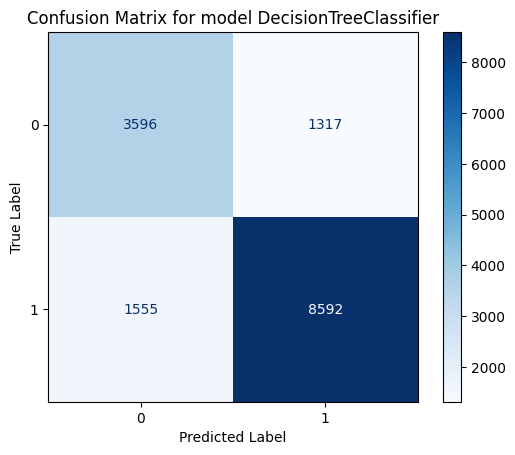

In [154]:
# Control the sample size using SMOTENC
# Determine the categorical feature indices
# Should already have categorical_feature_indices

# TODO : Create a dictionary sampling_strategy to set the class size
# TODO : Then apply SMOTENC to increase the required number of minorities to 75% of the number of majorities.
#!# BEGIN SOLUTION
class_counts = y_train.value_counts()
majority_class_count = class_counts.max()
minority_classes_count = class_counts.min()

# Set the desired minority class count to 75% of the majority class count
sampling_strategy = {
    class_counts.idxmin(): int(0.75 * majority_class_count),
    class_counts.idxmax(): majority_class_count
}

smotenc75 = SMOTENC(categorical_features=categorical_feature_indices, sampling_strategy=sampling_strategy, random_state=42)
X_train_smotenc75, y_train_smotenc75 = smotenc75.fit_resample(X_train, y_train)
#!# END SOLUTION

# Train and plot CART model
cart_smotenc75 = train_CART_onehot_print_plot(X_train_smotenc75, X_test, y_train_smotenc75, y_test)

We can check them by printing the sample size:

In [155]:
# Count the occurrences of each class
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_rus))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_ros))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_smotenc))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_smotenc75))

Number of 0s: 9782, Number of 1s: 20380
Number of 0s: 9782, Number of 1s: 9782
Number of 0s: 20380, Number of 1s: 20380
Number of 0s: 20380, Number of 1s: 20380
Number of 0s: 15285, Number of 1s: 20380


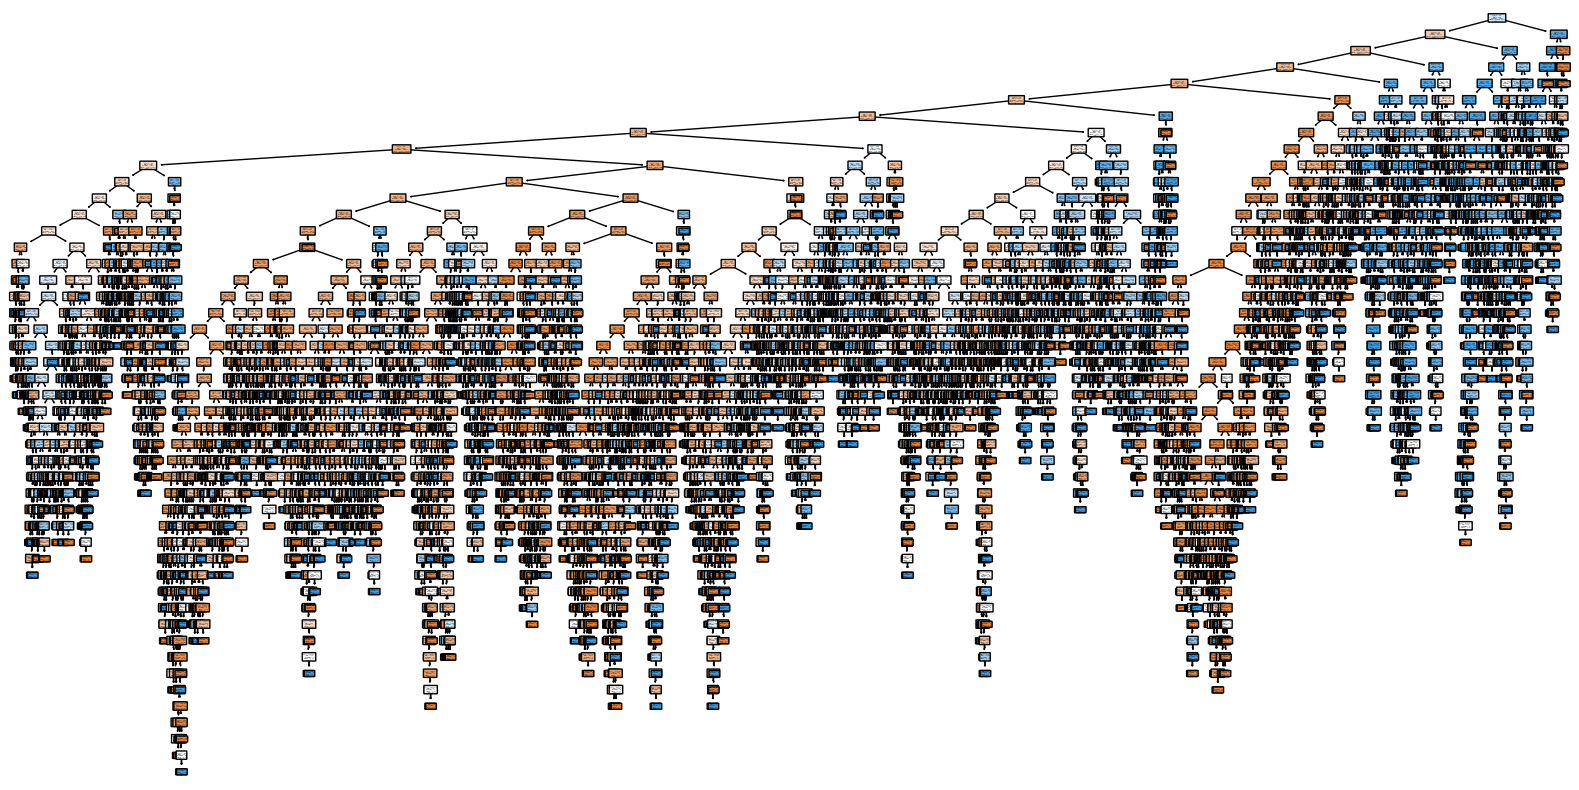

In [156]:
# Plot the tree, not necessary
# Very slow because the tree is too big
modelname = cart_smotenc75
plt.figure(figsize=(20,10))
plot_tree(modelname, 
          filled=True, 
          rounded=True, 
          class_names=list(map(str, modelname.classes_)))  # Update class names as appropriate)
plt.show()

## **4.** Random Forest & XGBoost

In this part, we will use the function in sklearn to perform the bagging and boosting. Specifically, we will use random forest and XGBoost. Let's go with random forest. Random forest accept only numerical data, we either need to do lable encoding or one hot encoding.

In [157]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

Firstly, let's do one hot encoding. Note that the parameters X_train and X_test are changed into encoded ones.

In [158]:
# TODO : Identify categorical columns and do one-hot encoding for them
#!# BEGIN SOLUTION
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
#!# END SOLUTION

# Check whether one-hot encoding succeeded through the datatype
if X_train_encoded.select_dtypes(include=['object']).empty and X_test_encoded.select_dtypes(include=['object']).empty:
    X_train = X_train_encoded
    X_test = X_test_encoded

Accuracy: 0.8428
False Negative Rate (FNR): 0.12989060806149602 && False Positive Rate (FPR): 0.2137187054752697


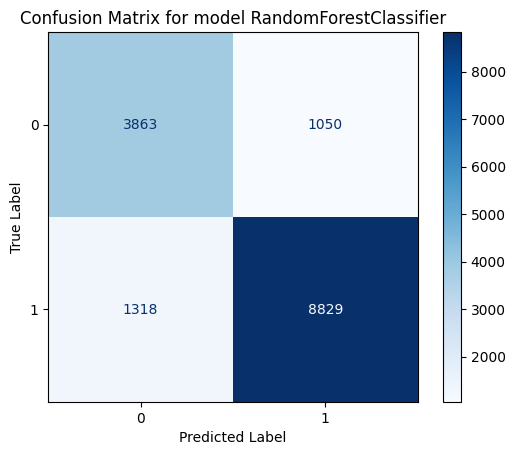

(0.12989060806149602, 0.2137187054752697)

In [159]:
# TODO : Apply a random forest classifier
#!# BEGIN SOLUTION
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
#!# END SOLUTION

print_plot_confusion_matrix(rf_model,X_test,y_test)

### Feature importances

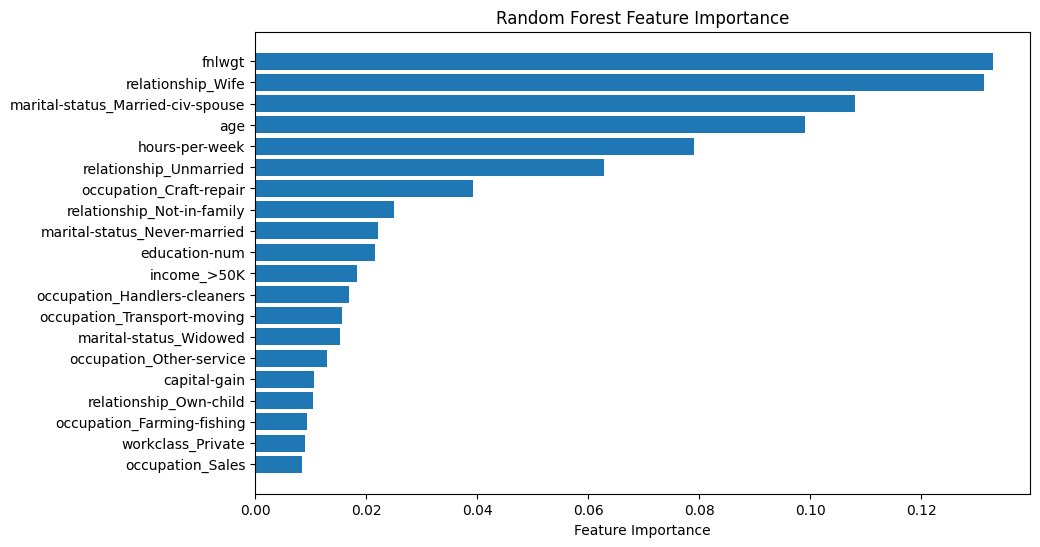

In [160]:
 # Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X_train.columns)

# Sort features based on importance and pick the first 20
sorted_idx = feature_importances.argsort()[-20:]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

Now try to use XGBoost.

You may need to install xgboost first:

$ pip install xgboost

Accuracy: 0.8518
False Negative Rate (FNR): 0.13353700601162904 && False Positive Rate (FPR): 0.17850600447791573


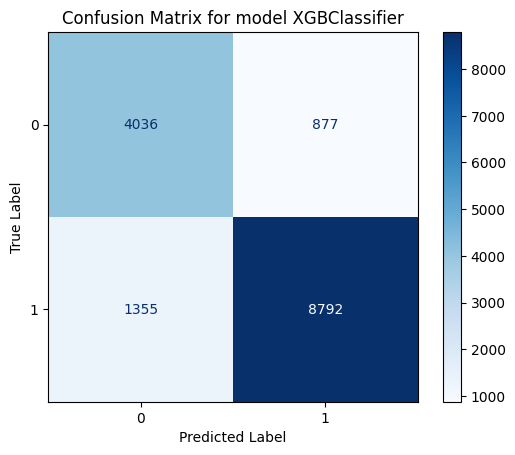

(0.13353700601162904, 0.17850600447791573)

In [161]:
# TODO : Apply a XGBoost classifier
#!# BEGIN SOLUTION
xgbcls_model = XGBClassifier(n_estimators=100, random_state=42)
xgbcls_model.fit(X_train, y_train)
#!# END SOLUTION

print_plot_confusion_matrix(xgbcls_model,X_test,y_test)

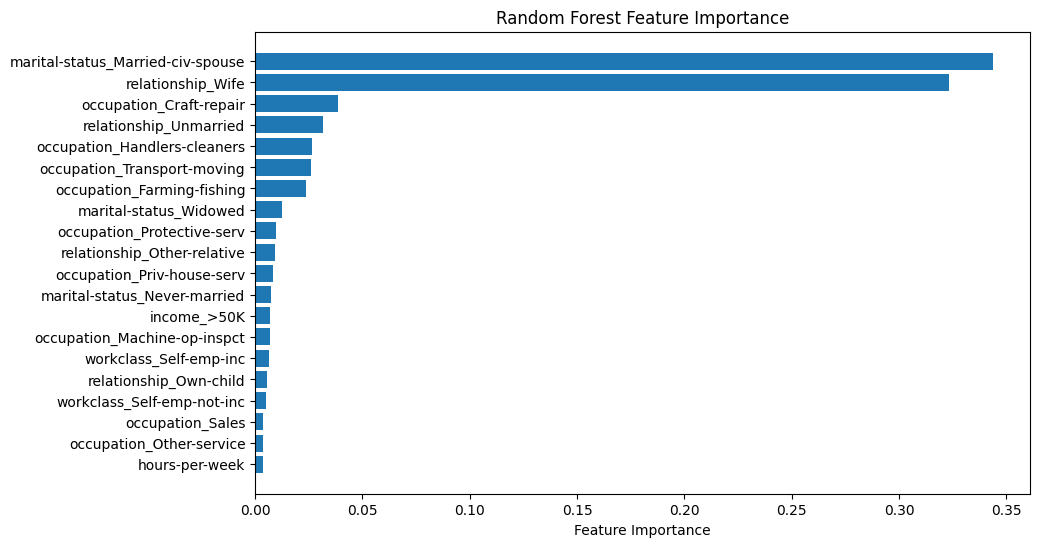

In [162]:
 # Get feature importances from the random forest model
feature_importances = xgbcls_model.feature_importances_

# Get the names of features
feature_names = list(X_train.columns)

# Sort features based on importance and pick the first 20
sorted_idx = feature_importances.argsort()[-20:]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

Let's start to check their bias and variance. You can directly use the following code to check complexities.

Note: It is a binary classfication task here. In this case, 0-1 loss is used as a substitute for measuring bias. If it is a regression task, you should directly calculate bias and variance.

*this part is very slow, you can reduce n_fold or delete some digit in n_estimator_list to make it faster.

In [163]:
def compute_accuracy_cv(X_model,X_train,y_train,n_fold=5):
    # Perform 50-fold cross-validation
    cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8888)
    accuracy_scores = cross_val_score(X_model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(accuracy_scores),np.var(accuracy_scores,ddof=1)

In [164]:
meanAccList = []
varAccList = []
modelNameList = []

In [165]:
# This part is very slow
# Around 5 mins for each of the following 3 cell
n_estimator_list = [5,10,50,100,200]
for nEst in n_estimator_list:
    rf_model = RandomForestClassifier(n_estimators=nEst, max_features='sqrt', random_state=42)
    meanAcc, varAcc = compute_accuracy_cv(rf_model, X_train, y_train)
    meanAccList.append(meanAcc)
    varAccList.append(varAcc)
    modelNameList.append("RF_%d"%(nEst))

In [166]:
n_depth_list = [7,10,13,15,18]
for nDepth in n_depth_list:
    max_depth_cart = DecisionTreeClassifier(max_depth=nDepth)
    meanAcc, varAcc = compute_accuracy_cv(max_depth_cart, X_train, y_train)
    meanAccList.append(meanAcc)
    varAccList.append(varAcc)
    modelNameList.append("CART_%d"%(nDepth))

In [167]:
n_estimator_list = [5,10,50,100,200]
for nEst in n_estimator_list:
    xgbcls_model = XGBClassifier(n_estimators=nEst, random_state=42)
    meanAcc, varAcc = compute_accuracy_cv(xgbcls_model, X_train, y_train)
    meanAccList.append(meanAcc)
    varAccList.append(varAcc)
    modelNameList.append("XGB_%d"%(nEst))

In [168]:
# Create a DataFrame
df = pd.DataFrame({
    'meanAccList': meanAccList,
    'varAccList': varAccList,
    'modelNameList': modelNameList
})
# Access the bias via 1 - accuracy
df['meanAccList'] = 1 - df['meanAccList']

# Sort the DataFrame by meanAccList
df_sorted = df.sort_values(by='meanAccList')
# Create a manual range
df_sorted['manual_range'] = range(df_sorted.shape[0])

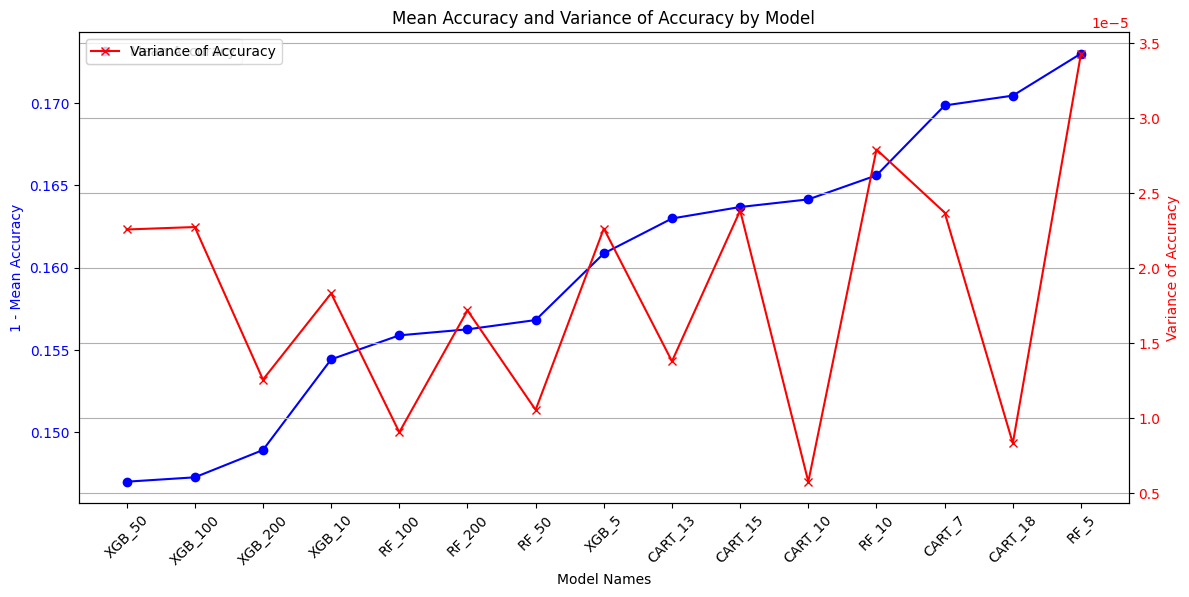

In [169]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean accuracy on the primary y-axis
ax1.plot(df_sorted['manual_range'], df_sorted['meanAccList'], label='Mean Accuracy', marker='o', color='b')
ax1.set_xlabel('Model Names')
ax1.set_ylabel('1 - Mean Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(df_sorted['manual_range'])
ax1.set_xticklabels(df_sorted['modelNameList'], rotation=45)

# Create a twin y-axis to plot variance
ax2 = ax1.twinx()
ax2.plot(df_sorted['manual_range'], df_sorted['varAccList'], label='Variance of Accuracy', marker='x', color='r')
ax2.set_ylabel('Variance of Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.tight_layout()  # Adjust layout to make room for x-tick labels
ax1.legend(loc='best')
ax2.legend(loc='best')

plt.title('Mean Accuracy and Variance of Accuracy by Model')
plt.grid(True)

plt.show()

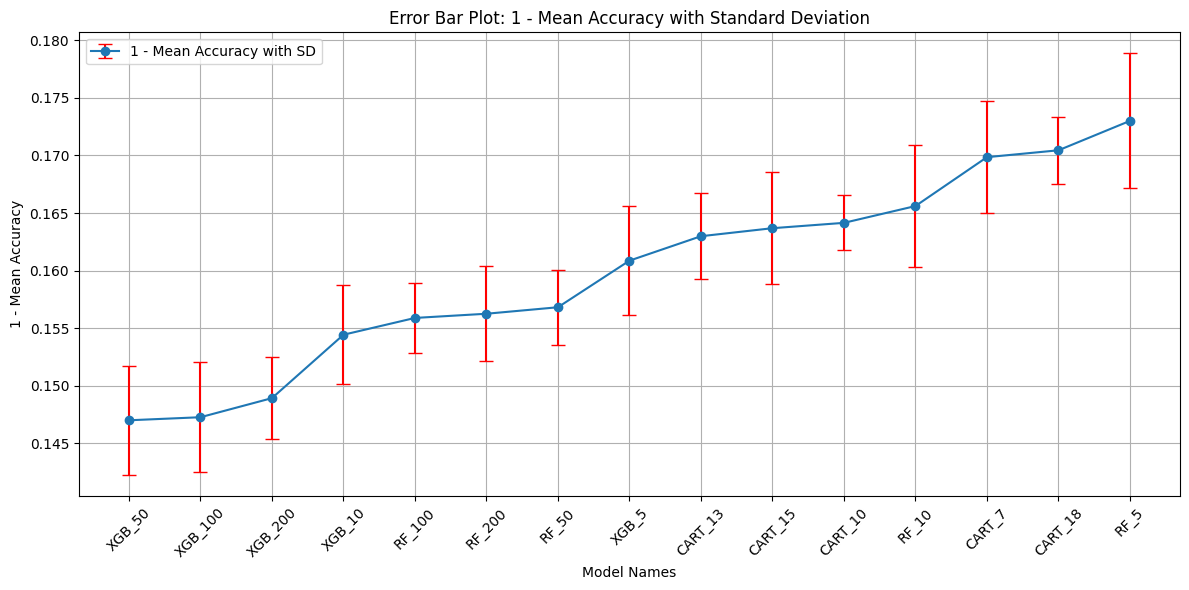

In [170]:
# Compute standard deviation from variance
df_sorted['stdAccList'] = np.sqrt(df_sorted['varAccList'])

# Create an error bar plot:
fig, ax = plt.subplots(figsize=(12, 6))

ax.errorbar(
    df_sorted['manual_range'], 
    df_sorted['meanAccList'], 
    yerr=df_sorted['stdAccList'], 
    fmt='o-', 
    ecolor='r', 
    capsize=5, 
    label='1 - Mean Accuracy with SD'
)

# Set the x-axis ticks and labels
ax.set_xticks(df_sorted['manual_range'])
ax.set_xticklabels(df_sorted['modelNameList'], rotation=45)
ax.set_xlabel('Model Names')
ax.set_ylabel('1 - Mean Accuracy')
ax.set_title('Error Bar Plot: 1 - Mean Accuracy with Standard Deviation')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## **5.** Ensemble Modeling: Bagging, Stacking and Voting

Now we want to create our own ensemble models. We will try bagging with kNN model, and then try voting and stacking. 

*The following models are made for learning purposes. This does not mean that they are the best models for the dataset, nor does it mean that they have been optimized.

In [171]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

Let's perform bagging with kNN model

In [172]:
# TODO : Define a kNN classifier
# TODO : Define a BaggingClassifier with kNN
# You can use the following parameters as a common choice.
# n_estimators=100,
# max_samples=0.8,
# max_features=0.8,
# bootstrap=True,
# bootstrap_features=False,
# random_state=42
#!# BEGIN SOLUTION
knn_model = KNeighborsClassifier()
bagging_model = BaggingClassifier(
    estimator=knn_model,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    random_state=42)
#!# END SOLUTION

# Fit the BaggingClassifier on the training data
bagging_model.fit(X_train, y_train)

# Predict on the test data
y_pred = bagging_model.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7142762284196548


Let's perform Voting

In [173]:
# Define the other classifiers
xgbcls_model = XGBClassifier(n_estimators=100, random_state=42)
max_depth_cart = DecisionTreeClassifier(max_depth=10)
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)

# TODO : Define a VotingClassifier classifier
# TODO : Use 'soft' voting to use predicted probabilities
# TODO : Use bagging_model and the above three models
#!# BEGIN SOLUTION
voting_model = VotingClassifier(
    estimators=[
        ('bagging', bagging_model),
        ('xgb', xgbcls_model),
        ('cart', max_depth_cart),
        ('rf', rf_model)
    ],
    voting='soft' )
#!# END SOLUTION

# Fit the VotingClassifier on the training data
voting_model.fit(X_train, y_train)

# Predict on the test data
y_pred = voting_model.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Predict probabilities on the test data
y_pred_proba = voting_model.predict_proba(X_test)

# Print the predicted probabilities for the first few samples
print(f"Predicted Probabilities for the first few samples:\n{y_pred_proba[:5]}")

Accuracy: 0.8596281540504648
Predicted Probabilities for the first few samples:
[[0.41047907 0.58952093]
 [0.08906051 0.91093949]
 [0.06604925 0.93395075]
 [0.02569103 0.97430897]
 [0.54063207 0.45936792]]


Let's perform stacking

In [174]:
# TODO : Define a list of base_models
# TODO : Use the same models in voting_model as base models
# TODO : Define a logistic regression as meta_model
# TODO : Define a StackingClassifier classifier
#!# BEGIN SOLUTION
base_models = [
    ('bagging', bagging_model),
    ('xgb', xgbcls_model),
    ('cart', max_depth_cart),
    ('rf', rf_model)
]

meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=False, cv=5)
#!# END SOLUTION

# Fit the StackingClassifier on the training data
stacking_model.fit(X_train, y_train)

# Predict on the test data
y_pred = stacking_model.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Predict probabilities on the test data
y_pred_proba = stacking_model.predict_proba(X_test)

# Print the predicted probabilities for the first few samples
print(f"Predicted Probabilities for the first few samples:\n{y_pred_proba[:5]}")

Accuracy: 0.8626826029216468
Predicted Probabilities for the first few samples:
[[0.29232481 0.70767519]
 [0.0279647  0.9720353 ]
 [0.02196679 0.97803321]
 [0.0138512  0.9861488 ]
 [0.61913956 0.38086044]]


# SUMMATIVE ASSESSMENT

Now pick a dataset of your choice. Please ensure your dataset is a csv file under 100MB named sem4_portfolio_5_data_custom.csv

Apply at least one resampling method, one pruned decision tree, and one self-created ensemble method to your dataset. 
Use any way you like to check at least one model for overfitting and underfitting. 
Make sure you are able to interpret all your results.

Note: Your model doesn't need to have great results at the end. But you need to be able to notice that.

In [175]:
custom_data_path = "sem4_portfolio_5_data_custom.csv"
custom_df = pd.read_csv(custom_data_path)

This dataset includes employees' basic features and the conditions of attrition. Attrition is the target column. Attrition means employees who left the organization. For more explanation on the column names, please check the excel in this folder. Now we are going to make use of this dataset to classify the staff's attrition based on these features. 

#### Part_1: Data Exploration & Processing

In [176]:
custom_df = custom_df.dropna()

In [177]:
display(custom_df.head())

,EmployeeID,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1,3,3,3.0,4.0,2.0,51,No,Travel_Rarely,Sales,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,2,2,4,3.0,2.0,4.0,31,Yes,Travel_Frequently,Research & Development,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,3,3,3,2.0,2.0,1.0,32,No,Travel_Frequently,Research & Development,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,4,2,3,4.0,4.0,3.0,38,No,Non-Travel,Research & Development,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,5,3,3,4.0,1.0,3.0,32,No,Travel_Rarely,Research & Development,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [178]:
mapping = {'no': 0, 'yes': 1} # 0 is no attrition, vice versa

# Create y using the "Attrition" column
y = custom_df['Attrition'].str.strip().str.lower().map(mapping)

X = custom_df.drop(columns=['Attrition'])

# Identify categorical columns (assuming they are of type 'object')
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Apply one-hot encoding using pandas get_dummies; drop_first to avoid dummy variable trap.
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)




In [179]:
y.value_counts()

Attrition
0    3605
1     695
Name: count, dtype: int64

Now we can see an imbalance within the original dataset. So we need to resample the dataset to keep it balanced. In the next step, we will first write some functions to plot our results, use three methods for resampling to improve the quality of our data and train a simple cart model for each method to compare their results.

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [181]:
# Check data types
X_train.dtypes

EmployeeID                             int64
JobInvolvement                         int64
PerformanceRating                      int64
EnvironmentSatisfaction              float64
JobSatisfaction                      float64
WorkLifeBalance                      float64
Age                                    int64
DistanceFromHome                       int64
Education                              int64
EmployeeCount                          int64
JobLevel                               int64
MonthlyIncome                          int64
NumCompaniesWorked                   float64
PercentSalaryHike                      int64
StandardHours                          int64
StockOptionLevel                       int64
TotalWorkingYears                    float64
TrainingTimesLastYear                  int64
YearsAtCompany                         int64
YearsSinceLastPromotion                int64
YearsWithCurrManager                   int64
BusinessTravel_Travel_Frequently        bool
BusinessTr

### Write functions for plotting, modeling, and metric computing...

In [182]:
def print_plot_confusion_matrix(modelname,X_test,y_test):
    # Making predictions
    predictions = modelname.predict(X_test)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute confusion_matrix
    labels_confu = np.unique(np.concatenate((y_test, predictions)))
    cm = confusion_matrix(y_test, predictions, labels=labels_confu)

    # Print FNR and FPR
    TN, FP, FN, TP = cm.ravel()
    FNR = FN / (FN + TP)
    FPR = FP / (FP + TN)
    print("False Negative Rate (FNR):", FNR, "&& False Positive Rate (FPR):", FPR)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_confu)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for model {modelname.__class__.__name__}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return FNR, FPR

In [183]:
def predict_plot_metric_and_tree(modelname,X_test,y_test):
    # Making predictions
    predictions = modelname.predict(X_test)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Compute confusion matrix
    labels_confu = np.unique(np.concatenate((y_test, predictions)))
    cm = confusion_matrix(y_test, predictions, labels=labels_confu)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_confu)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Heart Disease Prediction')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Plot the tree
    plt.figure(figsize=(20,10))
    plot_tree(modelname, 
              filled=True, 
              rounded=True, 
              class_names=list(map(str, modelname.classes_)),  # Update class names as appropriate
              feature_names=list(X_test.columns))       # Ensure X_test.columns is accessible
    plt.show()

In [184]:
def train_plain_CART_print_plot(X_train, X_test, y_train, y_test):
    # Train a simple CART and use the function print_plot_confusion_matrix
    cart_model = DecisionTreeClassifier(random_state=42)
    cart_model.fit(X_train, y_train)
    print_plot_confusion_matrix(cart_model, X_test, y_test)
    return cart_model

def train_CART_onehot_print_plot(X_train, X_test, y_train, y_test):
   
    # Identify categorical columns (assuming they are of type 'object')
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    # Apply one-hot encoding using pandas get_dummies; drop_first to avoid dummy variable trap.
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_encoded  = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

    # Align the dataframes so they have the same columns; fill missing dummy columns with 0.
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

    # Train CART using the encoded features.
    return train_plain_CART_print_plot(X_train_encoded, X_test_encoded, y_train, y_test)

In [185]:
def compute_accuracy_cv(X_model,X_train,y_train,n_fold=50):
    # Perform 50-fold cross-validation
    cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8888)
    accuracy_scores = cross_val_score(X_model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(accuracy_scores),np.var(accuracy_scores,ddof=1)

Accuracy: 0.9612
False Negative Rate (FNR): 0.09569377990430622 && False Positive Rate (FPR): 0.027752081406105456


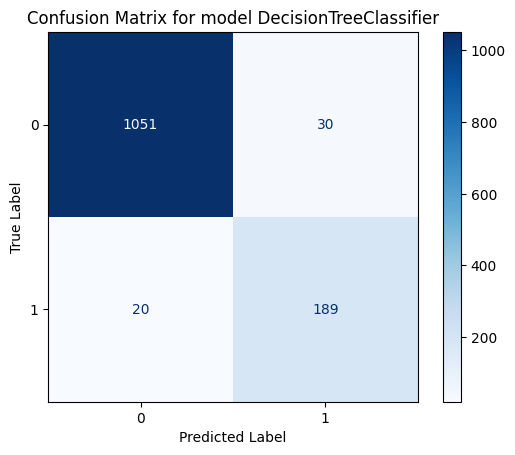

DecisionTreeClassifier(random_state=42)

In [186]:
train_CART_onehot_print_plot(X_train, X_test, y_train, y_test) # Train a model without resampling at first for comparison

### Let's comparing the data from different resampling methods and choose the best one

Apply an undersampling

Accuracy: 0.8078
False Negative Rate (FNR): 0.06698564593301436 && False Positive Rate (FPR): 0.21646623496762257


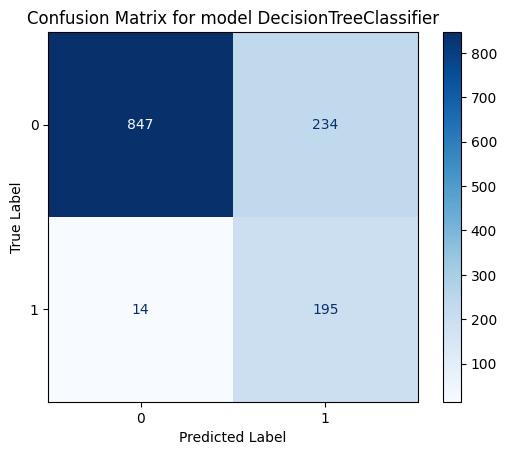

DecisionTreeClassifier(random_state=42)

In [187]:
# Apply an undersampling using RandomUnderSampler here for comparison
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

train_CART_onehot_print_plot(X_train_rus, X_test, y_train_rus, y_test)

Apply an oversampling

Accuracy: 0.9698
False Negative Rate (FNR): 0.08133971291866028 && False Positive Rate (FPR): 0.020351526364477335


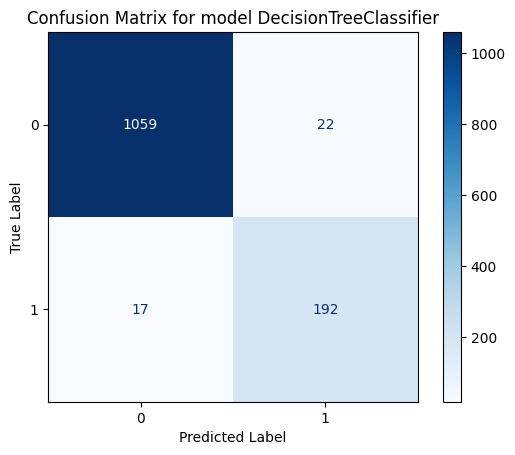

DecisionTreeClassifier(random_state=42)

In [188]:
# Oversampling using RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

train_CART_onehot_print_plot(X_train_ros, X_test, y_train_ros, y_test)

Accuracy: 0.9488
False Negative Rate (FNR): 0.10526315789473684 && False Positive Rate (FPR): 0.04070305272895467


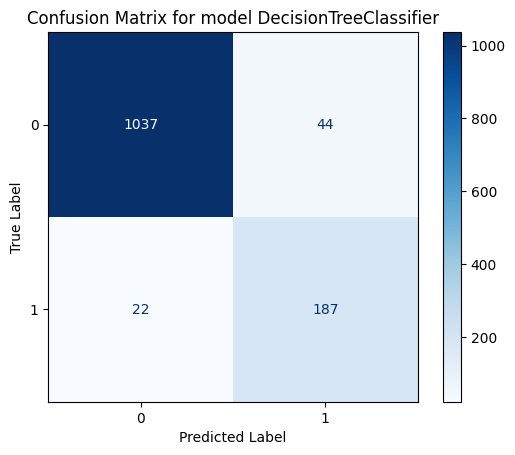

DecisionTreeClassifier(random_state=42)

In [189]:
# Oversampling using SMOTENC

# Identify categorical columns by checking for the 'object' dtype.
categorical_columns = X_train.select_dtypes(include=['bool']).columns.tolist()
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

# Apply SMOTENC() to implement an over-sampling with SMOTENC

smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

train_CART_onehot_print_plot(X_train_smotenc, X_test, y_train_smotenc, y_test)

Now check the size of data from each resampling method.

In [190]:
# Count the occurrences of each class
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_rus))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_ros))
(lambda counter: print(f"Number of 0s: {counter[0]}, Number of 1s: {counter[1]}"))(Counter(y_train_smotenc))

Number of 0s: 2524, Number of 1s: 486
Number of 0s: 486, Number of 1s: 486
Number of 0s: 2524, Number of 1s: 2524
Number of 0s: 2524, Number of 1s: 2524


From the comparison above, we can see that after oversampling with random over sampler, the simple cart model performs the best with a relatively high accuracy, and less False Negative rate. So we will continue with the data from random oversampling for the next.

### Now we are going to prune our tree by using cost-complexity pruning to improve our model's performance.

Index 0: ccp_alpha = 0.0
Index 1: ccp_alpha = 0.00019628084153593416
Index 2: ccp_alpha = 0.0001968364843994474
Index 3: ccp_alpha = 0.00019731834233874577
Index 4: ccp_alpha = 0.0003521746786406057
Index 5: ccp_alpha = 0.0003631801373481247
Index 6: ccp_alpha = 0.00037181518956479345
Index 7: ccp_alpha = 0.0003795009365540971
Index 8: ccp_alpha = 0.00038234348852415423
Index 9: ccp_alpha = 0.0003859500519154052
Index 10: ccp_alpha = 0.0003886897666621975
Index 11: ccp_alpha = 0.0003892456974448801
Index 12: ccp_alpha = 0.00038936553910049783
Index 13: ccp_alpha = 0.00039983383125850283
Index 14: ccp_alpha = 0.0005676067851201985
Index 15: ccp_alpha = 0.0005694758411366192
Index 16: ccp_alpha = 0.0005761020731588992
Index 17: ccp_alpha = 0.0005818270477541475
Index 18: ccp_alpha = 0.00061630568762106
Index 19: ccp_alpha = 0.0006704504679604102
Index 20: ccp_alpha = 0.0006867406233491813
Index 21: ccp_alpha = 0.0006993825628632466
Index 22: ccp_alpha = 0.0007234892854682008
Index 23: cc

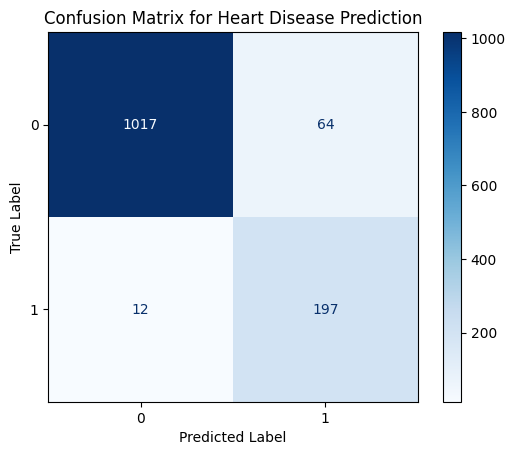

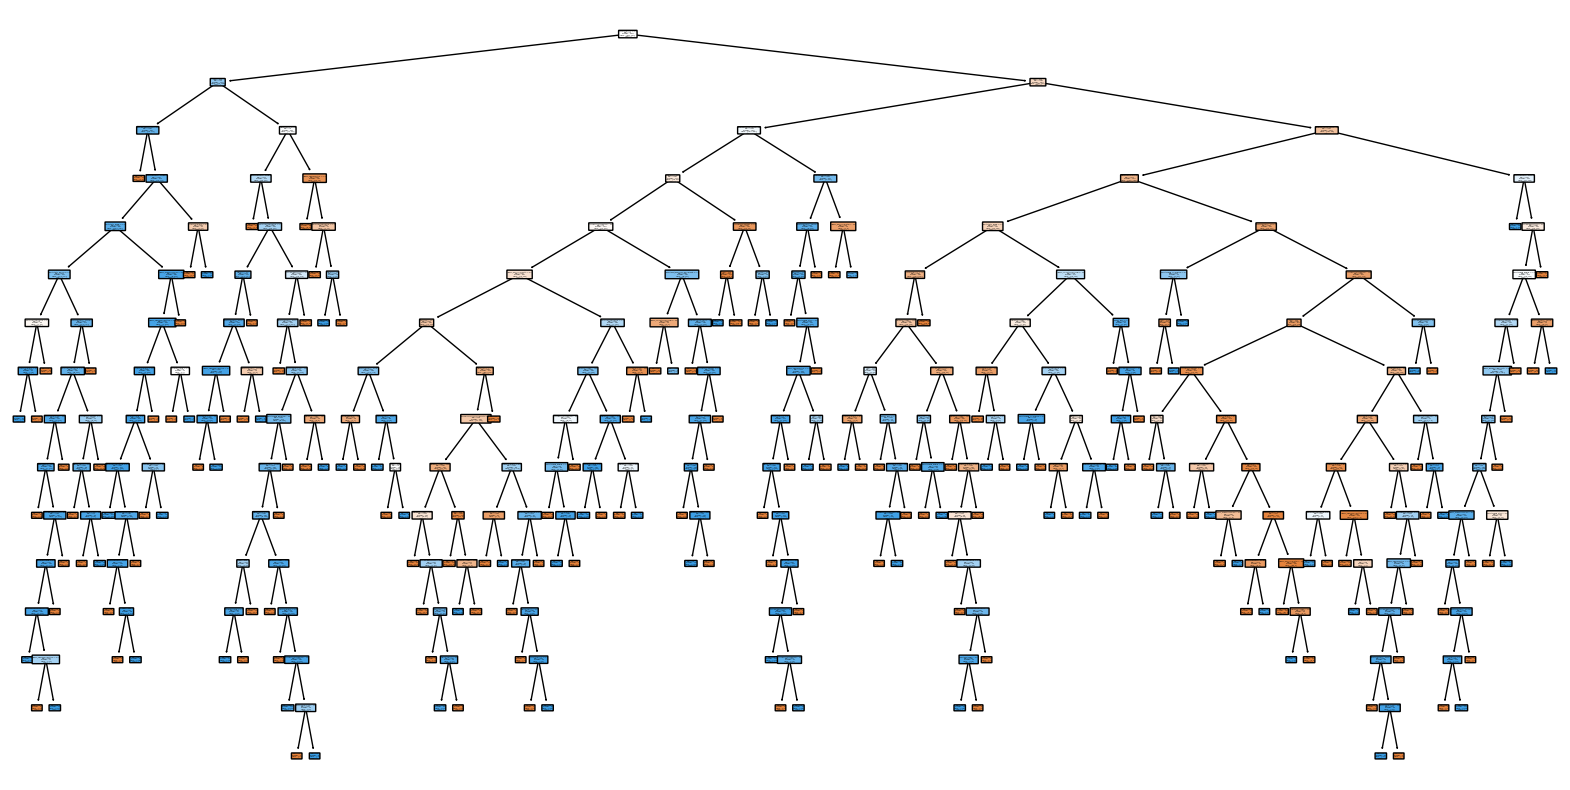

In [191]:
path = cart_model.cost_complexity_pruning_path(X_train_ros, y_train_ros)
ccp_alphas = path.ccp_alphas
ccp_alpha_model = DecisionTreeClassifier(ccp_alpha=ccp_alphas[18])

ccp_alpha_model.fit(X_train_ros, y_train_ros)
print("\n".join([f"Index {index}: ccp_alpha = {ccp_alpha}" for index, ccp_alpha in enumerate(ccp_alphas)]))
predict_plot_metric_and_tree(ccp_alpha_model,X_test,y_test)

### Now we are going to plot the model performance to see if there is overfitting or underfitting. It's helpful for us to select a proper ccp_alpha.

In [192]:
# Check if ccp_alphas is well defined
assert np.array_equal(ccp_alphas, path.ccp_alphas)

# Exclude the maximum value which would prune the entire tree
ccp_alphas = ccp_alphas[:-1]

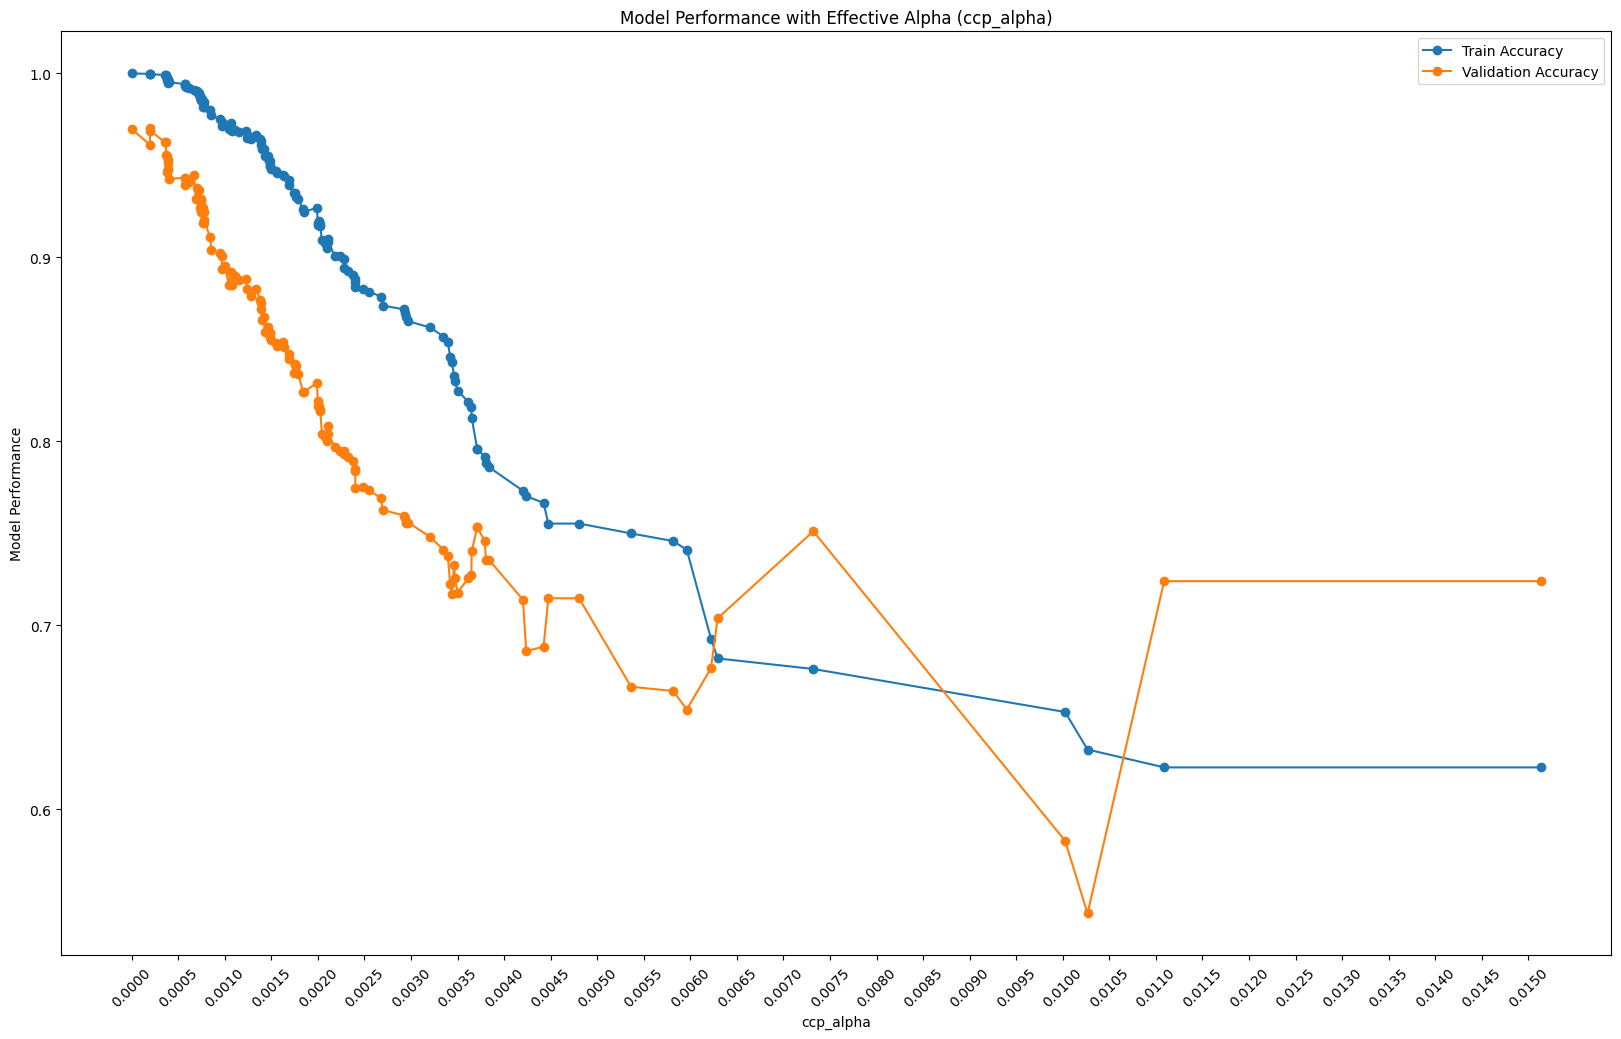

In [193]:
# Train trees using different ccp_alpha values and store their performance
train_scores = []
val_scores = []


for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    tree.fit(X_train_ros, y_train_ros)
    train_scores.append(accuracy_score(y_train_ros, tree.predict(X_train_ros)))
    val_scores.append(accuracy_score(y_test, tree.predict(X_test)))


# Plot the results
plt.figure(figsize=(20, 12))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train Accuracy')
plt.plot(ccp_alphas, val_scores, marker='o', label='Validation Accuracy')
plt.xticks(np.arange(ccp_alphas[0], ccp_alphas[-1], step=0.0005),rotation=45)
#plt.xlim(0.005,0.007)
plt.xlabel('ccp_alpha')
plt.ylabel('Model Performance')
plt.title('Model Performance with Effective Alpha (ccp_alpha)')
plt.legend()
plt.show()

When ccp_alpha is too small, the model overfits, as seen by the large gap between training and validation accuracies. When ccp_alpha is too large, the model becomes too simple, leading to underfitting, as both accuracies drop and stabilize at lower values. The best spot for ccp_alpha appears to be around 0.0060, where the validation accuracy is maximized, indicating the best trade-off between model complexity and generalization.

### In the following step, we are going to create our own ensemble model by bagging with KNN.

In [194]:
knn_model = KNeighborsClassifier()
bagging_model = BaggingClassifier(
    estimator=knn_model,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    random_state=42)

# Fit the BaggingClassifier on the training data
bagging_model.fit(X_train_ros, y_train_ros)

# Predict on the test data
y_pred = bagging_model.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6728682170542636


Now we will check their bias and variance by checking complexities.

In [195]:
def compute_accuracy_cv(X_model,X_train,y_train,n_fold=5):
    # Perform 50-fold cross-validation
    cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8888)
    accuracy_scores = cross_val_score(X_model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(accuracy_scores),np.var(accuracy_scores,ddof=1)

In [196]:
meanAccList = []
varAccList = []
modelNameList = []

In [197]:
n_estimator_list = [5,10,50,100,200] # Checking different estimators to check complexities
for nEst in n_estimator_list:
    knn_model = KNeighborsClassifier()
    bagging_model = BaggingClassifier(
        estimator=knn_model,
        n_estimators=nEst,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        bootstrap_features=False,
        random_state=42)
    meanAcc, varAcc = compute_accuracy_cv(bagging_model, X_train_ros, y_train_ros)
    meanAccList.append(meanAcc)
    varAccList.append(varAcc)
    modelNameList.append("KNN_%d"%(nEst))

In [198]:
# Create a DataFrame
df = pd.DataFrame({
    'meanAccList': meanAccList,
    'varAccList': varAccList,
    'modelNameList': modelNameList
})
# Access the bias via 1 - accuracy
df['meanAccList'] = 1 - df['meanAccList']

# Sort the DataFrame by meanAccList
df_sorted = df.sort_values(by='meanAccList')
# Create a manual range
df_sorted['manual_range'] = range(df_sorted.shape[0])

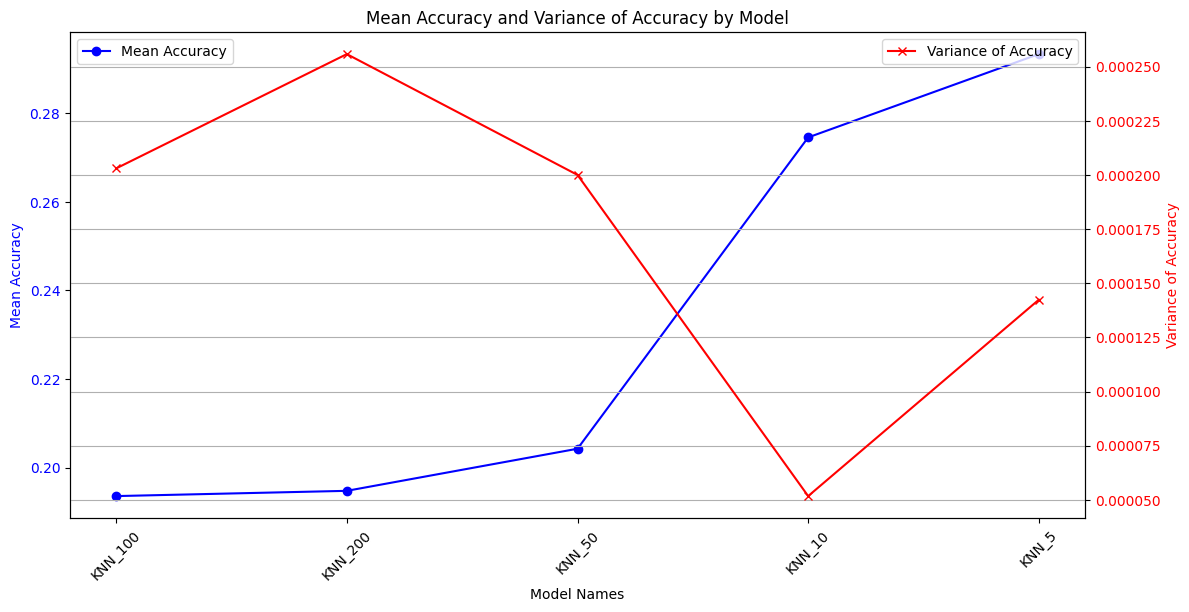

In [199]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean accuracy on the primary y-axis
ax1.plot(df_sorted['manual_range'], df_sorted['meanAccList'], label='Mean Accuracy', marker='o', color='b')
ax1.set_xlabel('Model Names')
ax1.set_ylabel('Mean Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(df_sorted['manual_range'])
ax1.set_xticklabels(df_sorted['modelNameList'], rotation=45)

# Create a twin y-axis to plot variance
ax2 = ax1.twinx()
ax2.plot(df_sorted['manual_range'], df_sorted['varAccList'], label='Variance of Accuracy', marker='x', color='r')
ax2.set_ylabel('Variance of Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.tight_layout()  # Adjust layout to make room for x-tick labels
ax1.legend(loc='best')
ax2.legend(loc='best')

plt.title('Mean Accuracy and Variance of Accuracy by Model')
plt.grid(True)

plt.show()

This graph compares the mean accuracy (blue line) and variance of accuracy (red line) for K-Nearest Neighbors (KNN) models with varying numbers of neighbors (K: 100, 200, 50, 10, 5).<br>

Mean Accuracy: Increases as K decreases, from less than 0.20 (KNN_100) to above 0.29 (KNN_5), showing better performance with fewer neighbors.<br>
Variance of Accuracy: Peaks at over 0.00025 for KNN_200, drops to a low of 0.00005 for KNN_10, then rises to almost 0.00015 for KNN_5, indicating inconsistent performance at the extremes.<br>
KNN_5 has the highest accuracy but moderate variance, while KNN_10 offers a balance of decent accuracy and the lowest variance (most consistent).

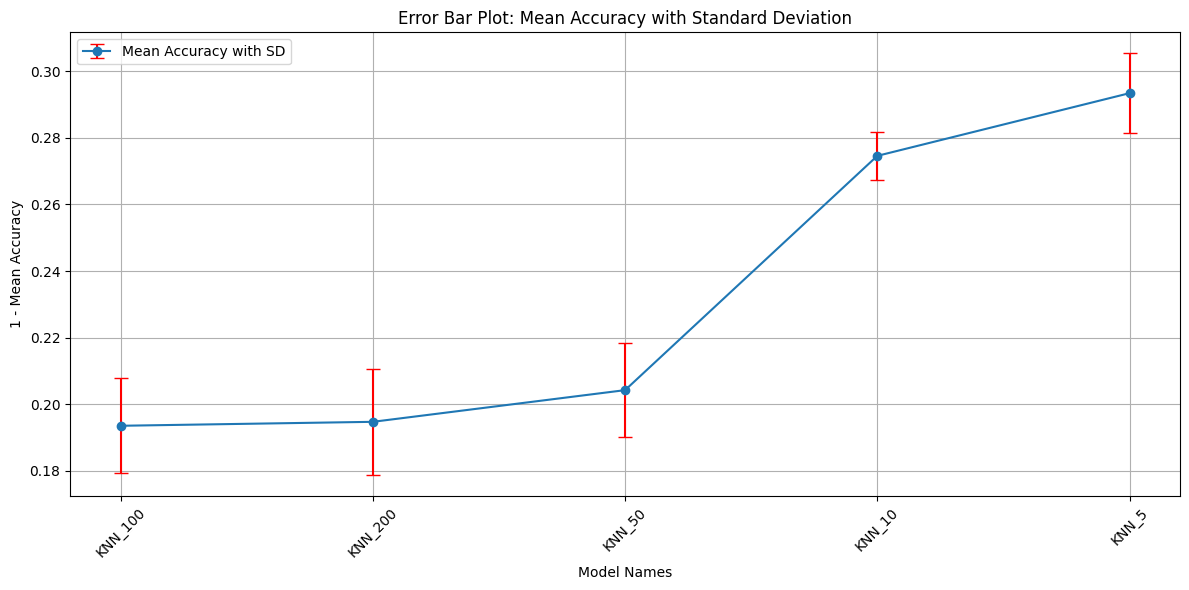

In [200]:
# Compute standard deviation from variance
df_sorted['stdAccList'] = np.sqrt(df_sorted['varAccList'])

# Create an error bar plot:
fig, ax = plt.subplots(figsize=(12, 6))

ax.errorbar(
    df_sorted['manual_range'], 
    df_sorted['meanAccList'], 
    yerr=df_sorted['stdAccList'], 
    fmt='o-', 
    ecolor='r', 
    capsize=5, 
    label='Mean Accuracy with SD'
)

# Set the x-axis ticks and labels
ax.set_xticks(df_sorted['manual_range'])
ax.set_xticklabels(df_sorted['modelNameList'], rotation=45)
ax.set_xlabel('Model Names')
ax.set_ylabel('1 - Mean Accuracy')
ax.set_title('Error Bar Plot: Mean Accuracy with Standard Deviation')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

This error bar plot shows the mean accuracy with standard deviation (red error bars) for K-Nearest Neighbors (KNN) models in the bagging with varying numbers of neighbors (K: 100, 200, 50, 10, 5). The x-axis lists the model names, and the y-axis represents mean accuracy (ranging from 0.18 to 0.30). <br>

Mean Accuracy: Starts at around 0.20 for KNN_100 and KNN_200, remains stable for KNN_50, then increases to about 0.27 for KNN_10, and peaks at 0.29 for KNN_5. This shows that accuracy improves as the number of neighbors decreases.<br>
Standard Deviation (Error Bars): The error bars are small and consistent across all models, indicating low variability in accuracy. The standard deviation appears slightly larger for KNN_5 compared to others, suggesting a bit more variation in its performance.<br>
Overall, KNN_5 achieves the highest mean accuracy (0.29), but with slightly higher variability. As K decreases, accuracy improves, with all models showing relatively stable performance due to the small error bars.